In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score, accuracy_score


import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import logging

from torch.cuda.amp import autocast, GradScaler

#seeds for reproducibility
np.random.seed(40)
torch.manual_seed(40)

data = pd.read_csv('/kaggle/input/dataset/combined_data.csv')
#dropping the columns that are not required like the filepath

data = data.drop(['matFilePath'], axis=1)
#data = data.drop(['Motor5Cmd'], axis=1) #to confirm, why 0 for all rows
data.info()

df = data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 13 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Timestamps            float64
 1   Motor1Cmd             float64
 2   Motor2Cmd             float64
 3   Motor3Cmd             float64
 4   Motor4Cmd             float64
 5   Motor5Cmd             int64  
 6   DesiredTrajectory-x   float64
 7   DesiredTrajectory-y   float64
 8   DesiredTrajectory-z   float64
 9   RealizedTrajectory-x  float64
 10  RealizedTrajectory-y  float64
 11  RealizedTrajectory-z  float64
 12  Target                object 
dtypes: float64(11), int64(1), object(1)
memory usage: 357.1+ MB


In [13]:
if torch.cuda.is_available():
    print("CUDA is available. GPU specs:")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
        print(f"  Memory Cached: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
        print(f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GB")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available. GPU specs:
GPU 0: Tesla T4
  Memory Allocated: 0.22 GB
  Memory Cached: 0.32 GB
  Total Memory: 14.74 GB
GPU 1: Tesla T4
  Memory Allocated: 0.04 GB
  Memory Cached: 0.04 GB
  Total Memory: 14.74 GB


In [44]:
torch.cuda.empty_cache()

# CDAN approach

CDAN model which includes a Feature Extractor, Label Predictor, and Domain Classifier with a Gradient Reversal Layer. The training involves both source and target data. The Feature Extractor is a transformer that processes sequences. Label Predictor handles classification, and the Domain Classifier distinguishes between source (synth data) and target domains using gradient reversal. The loss combines classification and domain adaptation losses.

The purpose of the domain classifier in CDAN is not to achieve perfect domain discrimination. In fact, the feature extractor is trained adversarially so that the domain classifier struggles—ideally reaching chance-level performance. A domain loss that stays relatively stable (or even remains moderately high) can indicate that the domain classifier is being confused by the features, which is what you want.

The LabelPredictor component of the CDAN model predicts class probabilities for the input features. This is done using the label_predictor module. The classifier predictions (softmax outputs) are used to condition the domain classifier. This is done by computing a tensor product (or an approximation of it) between the classifier predictions and the features extracted by the FeatureExtractor.conditioned features are then passed through a GradientReversal layer before being fed into the DomainClassifier. This layer reverses the gradients during backpropagation, which helps in aligning the conditional distributions of the source and target domains.

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-6-c2218c61bc75>:423: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training
Epoch 1 Training:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-6-c2218c61bc75>:467: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
Epoch 1 Validation: 100%|██████████| 90/90 [00:35<00:00,  2.54it/s]


Epoch 1: Train Loss: 3.8439 (Class: 2.2282, Domain: 1.6157), Train Acc: 11.46%, Val Loss: 2.1773, Val Acc: 14.06%


Epoch 2 Validation: 100%|██████████| 90/90 [00:34<00:00,  2.65it/s]


Epoch 2: Train Loss: 3.6347 (Class: 2.0886, Domain: 1.5461), Train Acc: 25.00%, Val Loss: 2.1457, Val Acc: 17.50%


Epoch 3 Validation: 100%|██████████| 90/90 [00:34<00:00,  2.64it/s]


Epoch 3: Train Loss: 3.6109 (Class: 2.1860, Domain: 1.4248), Train Acc: 13.54%, Val Loss: 2.1026, Val Acc: 19.55%


Epoch 4 Validation: 100%|██████████| 90/90 [00:34<00:00,  2.62it/s]


Epoch 4: Train Loss: 3.5822 (Class: 2.0846, Domain: 1.4976), Train Acc: 19.79%, Val Loss: 2.0198, Val Acc: 22.57%


Epoch 5 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.65it/s]


Epoch 5: Train Loss: 3.3918 (Class: 1.9452, Domain: 1.4467), Train Acc: 23.96%, Val Loss: 1.8718, Val Acc: 28.44%


Epoch 6 Validation: 100%|██████████| 90/90 [00:34<00:00,  2.62it/s]


Epoch 6: Train Loss: 3.3134 (Class: 1.8780, Domain: 1.4354), Train Acc: 33.33%, Val Loss: 1.8221, Val Acc: 31.42%


Epoch 7 Validation: 100%|██████████| 90/90 [00:34<00:00,  2.65it/s]


Epoch 7: Train Loss: 3.2863 (Class: 1.8196, Domain: 1.4667), Train Acc: 34.38%, Val Loss: 1.7771, Val Acc: 33.72%


Epoch 8 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.65it/s]


Epoch 8: Train Loss: 3.3004 (Class: 1.7751, Domain: 1.5253), Train Acc: 35.42%, Val Loss: 1.6991, Val Acc: 35.03%


Epoch 9 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.65it/s]


Epoch 9: Train Loss: 3.3698 (Class: 1.7805, Domain: 1.5893), Train Acc: 32.29%, Val Loss: 1.6647, Val Acc: 36.28%


Epoch 10 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Epoch 10: Train Loss: 3.2422 (Class: 1.6709, Domain: 1.5713), Train Acc: 33.33%, Val Loss: 1.4754, Val Acc: 41.08%


Epoch 11 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Epoch 11: Train Loss: 3.0597 (Class: 1.4186, Domain: 1.6411), Train Acc: 44.79%, Val Loss: 1.3986, Val Acc: 42.81%


Epoch 12 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Epoch 12: Train Loss: 3.0821 (Class: 1.5131, Domain: 1.5690), Train Acc: 38.54%, Val Loss: 1.4079, Val Acc: 45.76%


Epoch 13 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 13: Train Loss: 3.0667 (Class: 1.4552, Domain: 1.6116), Train Acc: 44.79%, Val Loss: 1.2595, Val Acc: 50.76%


Epoch 14 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Epoch 14: Train Loss: 2.8565 (Class: 1.2765, Domain: 1.5801), Train Acc: 50.00%, Val Loss: 1.4186, Val Acc: 40.80%


Epoch 15 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 15: Train Loss: 2.8365 (Class: 1.3294, Domain: 1.5070), Train Acc: 45.83%, Val Loss: 1.3646, Val Acc: 38.89%


Epoch 16 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.65it/s]


Epoch 16: Train Loss: 2.8312 (Class: 1.3111, Domain: 1.5201), Train Acc: 38.54%, Val Loss: 1.1436, Val Acc: 49.34%


Epoch 17 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 17: Train Loss: 2.4628 (Class: 1.0329, Domain: 1.4299), Train Acc: 64.58%, Val Loss: 1.2508, Val Acc: 47.15%


Epoch 18 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 18: Train Loss: 2.6272 (Class: 1.1383, Domain: 1.4889), Train Acc: 56.25%, Val Loss: 1.3536, Val Acc: 47.81%


Epoch 19 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Epoch 19: Train Loss: 2.8372 (Class: 1.3859, Domain: 1.4513), Train Acc: 42.71%, Val Loss: 1.3349, Val Acc: 42.29%


Epoch 20 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 20: Train Loss: 2.7345 (Class: 1.2862, Domain: 1.4483), Train Acc: 50.00%, Val Loss: 1.3027, Val Acc: 47.22%


Epoch 21 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 21: Train Loss: 2.5966 (Class: 1.0878, Domain: 1.5089), Train Acc: 58.33%, Val Loss: 1.2065, Val Acc: 50.00%


Epoch 22 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 22: Train Loss: 2.5954 (Class: 1.1702, Domain: 1.4252), Train Acc: 54.17%, Val Loss: 1.1367, Val Acc: 54.55%


Epoch 23 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 23: Train Loss: 2.5503 (Class: 1.0324, Domain: 1.5178), Train Acc: 54.17%, Val Loss: 1.4076, Val Acc: 46.94%


Epoch 24 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 24: Train Loss: 2.6838 (Class: 1.2459, Domain: 1.4380), Train Acc: 48.96%, Val Loss: 1.0461, Val Acc: 60.87%


Epoch 25 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 25: Train Loss: 2.4145 (Class: 0.8663, Domain: 1.5482), Train Acc: 70.83%, Val Loss: 1.1331, Val Acc: 52.67%


Epoch 26 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 26: Train Loss: 2.4534 (Class: 1.0303, Domain: 1.4231), Train Acc: 58.33%, Val Loss: 1.1187, Val Acc: 52.99%


Epoch 27 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 27: Train Loss: 2.4766 (Class: 0.9667, Domain: 1.5099), Train Acc: 62.50%, Val Loss: 0.9932, Val Acc: 62.15%


Epoch 28 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 28: Train Loss: 2.5644 (Class: 0.9937, Domain: 1.5706), Train Acc: 61.46%, Val Loss: 1.0367, Val Acc: 60.42%


Epoch 29 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 29: Train Loss: 2.3354 (Class: 0.7960, Domain: 1.5394), Train Acc: 66.67%, Val Loss: 0.9481, Val Acc: 61.49%


Epoch 30 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 30: Train Loss: 2.3238 (Class: 0.8830, Domain: 1.4409), Train Acc: 66.67%, Val Loss: 0.8502, Val Acc: 64.76%


Epoch 31 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 31: Train Loss: 2.1319 (Class: 0.7329, Domain: 1.3990), Train Acc: 71.88%, Val Loss: 0.8413, Val Acc: 64.10%


Epoch 32 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 32: Train Loss: 2.1950 (Class: 0.7054, Domain: 1.4897), Train Acc: 72.92%, Val Loss: 0.9139, Val Acc: 61.11%


Epoch 33 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Epoch 33: Train Loss: 2.3957 (Class: 0.8773, Domain: 1.5184), Train Acc: 60.42%, Val Loss: 0.7878, Val Acc: 64.83%


Epoch 34 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 34: Train Loss: 2.3522 (Class: 0.8837, Domain: 1.4685), Train Acc: 61.46%, Val Loss: 0.7512, Val Acc: 69.76%


Epoch 35 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 35: Train Loss: 2.3090 (Class: 0.8162, Domain: 1.4928), Train Acc: 63.54%, Val Loss: 0.7165, Val Acc: 69.79%


Epoch 36 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 36: Train Loss: 2.4179 (Class: 0.8832, Domain: 1.5348), Train Acc: 67.71%, Val Loss: 0.7229, Val Acc: 69.69%


Epoch 37 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 37: Train Loss: 2.3302 (Class: 0.8602, Domain: 1.4699), Train Acc: 68.75%, Val Loss: 0.7411, Val Acc: 70.76%


Epoch 38 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 38: Train Loss: 2.3922 (Class: 0.8666, Domain: 1.5256), Train Acc: 66.67%, Val Loss: 0.7040, Val Acc: 70.87%


Epoch 39 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 39: Train Loss: 2.1740 (Class: 0.7295, Domain: 1.4445), Train Acc: 69.79%, Val Loss: 0.7719, Val Acc: 70.14%


Epoch 40 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 40: Train Loss: 2.3308 (Class: 0.8027, Domain: 1.5281), Train Acc: 67.71%, Val Loss: 0.6707, Val Acc: 74.86%


Epoch 41 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.70it/s]


Epoch 41: Train Loss: 2.2519 (Class: 0.7342, Domain: 1.5177), Train Acc: 70.83%, Val Loss: 0.7454, Val Acc: 69.44%


Epoch 42 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 42: Train Loss: 2.2388 (Class: 0.7864, Domain: 1.4525), Train Acc: 65.62%, Val Loss: 0.9034, Val Acc: 64.76%


Epoch 43 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 43: Train Loss: 2.1633 (Class: 0.7637, Domain: 1.3996), Train Acc: 63.54%, Val Loss: 0.6544, Val Acc: 76.88%


Epoch 44 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 44: Train Loss: 1.9613 (Class: 0.5294, Domain: 1.4318), Train Acc: 80.21%, Val Loss: 0.6755, Val Acc: 72.26%


Epoch 45 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 45: Train Loss: 2.3563 (Class: 0.8856, Domain: 1.4707), Train Acc: 67.71%, Val Loss: 0.6687, Val Acc: 73.92%


Epoch 46 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Epoch 46: Train Loss: 2.0702 (Class: 0.5591, Domain: 1.5112), Train Acc: 82.29%, Val Loss: 0.8274, Val Acc: 66.77%


Epoch 47 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.70it/s]


Epoch 47: Train Loss: 2.2515 (Class: 0.7932, Domain: 1.4583), Train Acc: 68.75%, Val Loss: 0.6201, Val Acc: 75.76%


Epoch 48 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 48: Train Loss: 2.1023 (Class: 0.6974, Domain: 1.4050), Train Acc: 76.04%, Val Loss: 0.8562, Val Acc: 65.76%


Epoch 49 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 49: Train Loss: 2.2132 (Class: 0.7658, Domain: 1.4474), Train Acc: 73.96%, Val Loss: 0.8819, Val Acc: 65.52%


Epoch 50 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 50: Train Loss: 2.2711 (Class: 0.8149, Domain: 1.4561), Train Acc: 63.54%, Val Loss: 0.6196, Val Acc: 75.42%


Epoch 51 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 51: Train Loss: 2.2807 (Class: 0.8448, Domain: 1.4359), Train Acc: 65.62%, Val Loss: 1.2246, Val Acc: 54.48%


Epoch 52 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.70it/s]


Epoch 52: Train Loss: 2.2508 (Class: 0.7760, Domain: 1.4748), Train Acc: 69.79%, Val Loss: 0.8134, Val Acc: 67.01%


Epoch 53 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 53: Train Loss: 2.0787 (Class: 0.5999, Domain: 1.4788), Train Acc: 77.08%, Val Loss: 0.7381, Val Acc: 69.90%


Epoch 54 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 54: Train Loss: 2.1643 (Class: 0.7635, Domain: 1.4008), Train Acc: 70.83%, Val Loss: 0.6315, Val Acc: 73.02%


Epoch 55 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Epoch 55: Train Loss: 2.1331 (Class: 0.6818, Domain: 1.4514), Train Acc: 65.62%, Val Loss: 0.7973, Val Acc: 67.95%


Epoch 56 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 56: Train Loss: 2.1854 (Class: 0.7371, Domain: 1.4483), Train Acc: 71.88%, Val Loss: 0.7560, Val Acc: 70.17%


Epoch 57 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 57: Train Loss: 2.1480 (Class: 0.6890, Domain: 1.4590), Train Acc: 71.88%, Val Loss: 0.7574, Val Acc: 69.58%


Epoch 58 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Epoch 58: Train Loss: 2.0404 (Class: 0.6629, Domain: 1.3775), Train Acc: 78.12%, Val Loss: 0.7540, Val Acc: 69.65%


Epoch 59 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 59: Train Loss: 2.0471 (Class: 0.6290, Domain: 1.4181), Train Acc: 76.04%, Val Loss: 0.7290, Val Acc: 70.31%


Epoch 60 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 60: Train Loss: 1.8747 (Class: 0.4373, Domain: 1.4374), Train Acc: 84.38%, Val Loss: 0.6226, Val Acc: 78.12%


Epoch 61 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 61: Train Loss: 2.0098 (Class: 0.6019, Domain: 1.4080), Train Acc: 79.17%, Val Loss: 0.5752, Val Acc: 79.72%


Epoch 62 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 62: Train Loss: 2.0700 (Class: 0.6452, Domain: 1.4248), Train Acc: 81.25%, Val Loss: 0.5301, Val Acc: 80.24%


Epoch 63 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 63: Train Loss: 2.1593 (Class: 0.7065, Domain: 1.4527), Train Acc: 73.96%, Val Loss: 0.5357, Val Acc: 78.09%


Epoch 64 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 64: Train Loss: 2.0301 (Class: 0.5331, Domain: 1.4971), Train Acc: 82.29%, Val Loss: 0.5157, Val Acc: 78.99%


Epoch 65 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Epoch 65: Train Loss: 2.0330 (Class: 0.5947, Domain: 1.4383), Train Acc: 80.21%, Val Loss: 0.5105, Val Acc: 79.10%


Epoch 66 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 66: Train Loss: 2.0787 (Class: 0.6556, Domain: 1.4231), Train Acc: 69.79%, Val Loss: 0.5070, Val Acc: 78.40%


Epoch 67 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 67: Train Loss: 1.9169 (Class: 0.4760, Domain: 1.4409), Train Acc: 82.29%, Val Loss: 0.5051, Val Acc: 78.68%


Epoch 68 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 68: Train Loss: 1.9238 (Class: 0.5237, Domain: 1.4001), Train Acc: 82.29%, Val Loss: 0.5000, Val Acc: 78.51%


Epoch 69 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 69: Train Loss: 2.0195 (Class: 0.5545, Domain: 1.4650), Train Acc: 77.08%, Val Loss: 0.4899, Val Acc: 79.86%


Epoch 70 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 70: Train Loss: 1.9159 (Class: 0.4427, Domain: 1.4733), Train Acc: 83.33%, Val Loss: 0.4628, Val Acc: 81.84%


Epoch 71 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 71: Train Loss: 1.8432 (Class: 0.4295, Domain: 1.4137), Train Acc: 86.46%, Val Loss: 0.4330, Val Acc: 83.06%


Epoch 72 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 72: Train Loss: 2.0272 (Class: 0.5876, Domain: 1.4396), Train Acc: 81.25%, Val Loss: 0.4313, Val Acc: 82.95%


Epoch 73 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 73: Train Loss: 1.9061 (Class: 0.4266, Domain: 1.4795), Train Acc: 83.33%, Val Loss: 0.4828, Val Acc: 79.41%


Epoch 74 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 74: Train Loss: 2.0002 (Class: 0.5587, Domain: 1.4415), Train Acc: 81.25%, Val Loss: 0.5024, Val Acc: 77.53%


Epoch 75 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 75: Train Loss: 2.0145 (Class: 0.5727, Domain: 1.4418), Train Acc: 80.21%, Val Loss: 0.4625, Val Acc: 79.69%


Epoch 76 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 76: Train Loss: 1.8368 (Class: 0.4372, Domain: 1.3997), Train Acc: 87.50%, Val Loss: 0.4594, Val Acc: 79.34%


Epoch 77 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 77: Train Loss: 1.8009 (Class: 0.3548, Domain: 1.4461), Train Acc: 84.38%, Val Loss: 0.4193, Val Acc: 82.12%


Epoch 78 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Epoch 78: Train Loss: 1.6959 (Class: 0.2407, Domain: 1.4552), Train Acc: 93.75%, Val Loss: 0.4163, Val Acc: 82.92%


Epoch 79 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 79: Train Loss: 1.9347 (Class: 0.5050, Domain: 1.4297), Train Acc: 80.21%, Val Loss: 0.4322, Val Acc: 82.26%


Epoch 80 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 80: Train Loss: 1.9273 (Class: 0.4821, Domain: 1.4452), Train Acc: 84.38%, Val Loss: 0.4685, Val Acc: 80.45%


Epoch 81 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 81: Train Loss: 1.9331 (Class: 0.4490, Domain: 1.4840), Train Acc: 82.29%, Val Loss: 0.5045, Val Acc: 78.12%


Epoch 82 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 82: Train Loss: 1.9311 (Class: 0.4932, Domain: 1.4379), Train Acc: 73.96%, Val Loss: 0.5001, Val Acc: 77.99%


Epoch 83 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 83: Train Loss: 1.9429 (Class: 0.4807, Domain: 1.4622), Train Acc: 77.08%, Val Loss: 0.4673, Val Acc: 79.27%


Epoch 84 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 84: Train Loss: 2.0517 (Class: 0.5869, Domain: 1.4647), Train Acc: 78.12%, Val Loss: 0.4297, Val Acc: 81.32%


Epoch 85 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Epoch 85: Train Loss: 1.8514 (Class: 0.3958, Domain: 1.4556), Train Acc: 88.54%, Val Loss: 0.3992, Val Acc: 83.40%


Epoch 86 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 86: Train Loss: 1.9266 (Class: 0.4439, Domain: 1.4827), Train Acc: 86.46%, Val Loss: 0.3756, Val Acc: 84.65%


Epoch 87 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 87: Train Loss: 1.8697 (Class: 0.3852, Domain: 1.4845), Train Acc: 86.46%, Val Loss: 0.3675, Val Acc: 85.07%


Epoch 88 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Epoch 88: Train Loss: 1.9162 (Class: 0.4478, Domain: 1.4684), Train Acc: 83.33%, Val Loss: 0.3671, Val Acc: 85.17%


Epoch 89 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 89: Train Loss: 1.9018 (Class: 0.4231, Domain: 1.4788), Train Acc: 82.29%, Val Loss: 0.3862, Val Acc: 83.85%


Epoch 90 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Epoch 90: Train Loss: 1.8936 (Class: 0.4328, Domain: 1.4608), Train Acc: 84.38%, Val Loss: 0.4123, Val Acc: 82.40%


Epoch 91 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 91: Train Loss: 1.8951 (Class: 0.3802, Domain: 1.5149), Train Acc: 84.38%, Val Loss: 0.4166, Val Acc: 82.05%


Epoch 92 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 92: Train Loss: 1.9036 (Class: 0.4303, Domain: 1.4734), Train Acc: 83.33%, Val Loss: 0.4405, Val Acc: 80.90%


Epoch 93 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Epoch 93: Train Loss: 2.0001 (Class: 0.5025, Domain: 1.4976), Train Acc: 83.33%, Val Loss: 0.3920, Val Acc: 83.06%


Epoch 94 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 94: Train Loss: 1.9217 (Class: 0.4290, Domain: 1.4926), Train Acc: 84.38%, Val Loss: 0.3817, Val Acc: 83.72%


Epoch 95 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 95: Train Loss: 1.9315 (Class: 0.4350, Domain: 1.4965), Train Acc: 84.38%, Val Loss: 0.3832, Val Acc: 83.99%


Epoch 96 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 96: Train Loss: 1.9229 (Class: 0.4137, Domain: 1.5092), Train Acc: 84.38%, Val Loss: 0.3708, Val Acc: 84.51%


Epoch 97 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 97: Train Loss: 1.8114 (Class: 0.3698, Domain: 1.4416), Train Acc: 89.58%, Val Loss: 0.3618, Val Acc: 84.93%


Epoch 98 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 98: Train Loss: 1.7647 (Class: 0.3233, Domain: 1.4414), Train Acc: 90.62%, Val Loss: 0.3563, Val Acc: 85.31%


Epoch 99 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 99: Train Loss: 1.7504 (Class: 0.3084, Domain: 1.4419), Train Acc: 90.62%, Val Loss: 0.3643, Val Acc: 84.48%


Epoch 100 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 100: Train Loss: 1.9130 (Class: 0.3943, Domain: 1.5187), Train Acc: 88.54%, Val Loss: 0.3689, Val Acc: 84.20%


Epoch 101 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 101: Train Loss: 1.8983 (Class: 0.4155, Domain: 1.4829), Train Acc: 84.38%, Val Loss: 0.3508, Val Acc: 85.17%


Epoch 102 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 102: Train Loss: 1.8365 (Class: 0.3924, Domain: 1.4441), Train Acc: 86.46%, Val Loss: 0.3478, Val Acc: 85.28%


Epoch 103 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 103: Train Loss: 1.9731 (Class: 0.5040, Domain: 1.4692), Train Acc: 77.08%, Val Loss: 0.3633, Val Acc: 84.55%


Epoch 104 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 104: Train Loss: 1.9464 (Class: 0.4420, Domain: 1.5044), Train Acc: 83.33%, Val Loss: 0.3627, Val Acc: 84.79%


Epoch 105 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 105: Train Loss: 1.9093 (Class: 0.4076, Domain: 1.5018), Train Acc: 87.50%, Val Loss: 0.3632, Val Acc: 84.58%


Epoch 106 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 106: Train Loss: 1.9408 (Class: 0.4389, Domain: 1.5019), Train Acc: 83.33%, Val Loss: 0.3800, Val Acc: 83.65%


Epoch 107 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 107: Train Loss: 1.8296 (Class: 0.3583, Domain: 1.4714), Train Acc: 87.50%, Val Loss: 0.3871, Val Acc: 83.30%


Epoch 108 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 108: Train Loss: 1.7533 (Class: 0.2775, Domain: 1.4757), Train Acc: 91.67%, Val Loss: 0.3878, Val Acc: 83.44%


Epoch 109 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 109: Train Loss: 2.0229 (Class: 0.4802, Domain: 1.5428), Train Acc: 84.38%, Val Loss: 0.3804, Val Acc: 83.75%


Epoch 110 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 110: Train Loss: 1.9967 (Class: 0.5188, Domain: 1.4779), Train Acc: 81.25%, Val Loss: 0.3804, Val Acc: 83.78%


Epoch 111 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 111: Train Loss: 1.9768 (Class: 0.4496, Domain: 1.5272), Train Acc: 86.46%, Val Loss: 0.3698, Val Acc: 84.48%


Epoch 112 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 112: Train Loss: 1.8602 (Class: 0.3958, Domain: 1.4644), Train Acc: 88.54%, Val Loss: 0.3570, Val Acc: 85.14%


Epoch 113 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 113: Train Loss: 1.9202 (Class: 0.3897, Domain: 1.5305), Train Acc: 84.38%, Val Loss: 0.3567, Val Acc: 85.31%


Epoch 114 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 114: Train Loss: 2.0110 (Class: 0.4720, Domain: 1.5390), Train Acc: 85.42%, Val Loss: 0.3574, Val Acc: 85.10%


Epoch 115 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 115: Train Loss: 1.8184 (Class: 0.3421, Domain: 1.4763), Train Acc: 89.58%, Val Loss: 0.3617, Val Acc: 85.07%


Epoch 116 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 116: Train Loss: 1.8223 (Class: 0.3349, Domain: 1.4874), Train Acc: 89.58%, Val Loss: 0.3604, Val Acc: 84.97%


Epoch 117 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 117: Train Loss: 1.9189 (Class: 0.3433, Domain: 1.5756), Train Acc: 90.62%, Val Loss: 0.3731, Val Acc: 84.34%


Epoch 118 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 118: Train Loss: 1.9072 (Class: 0.4231, Domain: 1.4841), Train Acc: 88.54%, Val Loss: 0.3647, Val Acc: 84.90%


Epoch 119 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 119: Train Loss: 1.8595 (Class: 0.3840, Domain: 1.4755), Train Acc: 85.42%, Val Loss: 0.3698, Val Acc: 84.55%


Epoch 120 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Epoch 120: Train Loss: 1.9903 (Class: 0.4789, Domain: 1.5114), Train Acc: 84.38%, Val Loss: 0.3683, Val Acc: 84.72%


Epoch 121 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 121: Train Loss: 1.9458 (Class: 0.4718, Domain: 1.4739), Train Acc: 77.08%, Val Loss: 0.3582, Val Acc: 85.17%


Epoch 122 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 122: Train Loss: 1.9083 (Class: 0.4389, Domain: 1.4694), Train Acc: 86.46%, Val Loss: 0.3549, Val Acc: 85.35%


Epoch 123 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Epoch 123: Train Loss: 1.8606 (Class: 0.3938, Domain: 1.4668), Train Acc: 87.50%, Val Loss: 0.3559, Val Acc: 85.28%


Epoch 124 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 124: Train Loss: 1.8309 (Class: 0.3195, Domain: 1.5115), Train Acc: 87.50%, Val Loss: 0.3632, Val Acc: 84.62%


Epoch 125 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Epoch 125: Train Loss: 1.7761 (Class: 0.3510, Domain: 1.4251), Train Acc: 89.58%, Val Loss: 0.3589, Val Acc: 85.00%


Epoch 126 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.69it/s]


Epoch 126: Train Loss: 1.8513 (Class: 0.3746, Domain: 1.4767), Train Acc: 86.46%, Val Loss: 0.3545, Val Acc: 85.14%


Epoch 127 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Epoch 127: Train Loss: 1.8317 (Class: 0.3341, Domain: 1.4976), Train Acc: 87.50%, Val Loss: 0.3480, Val Acc: 85.56%


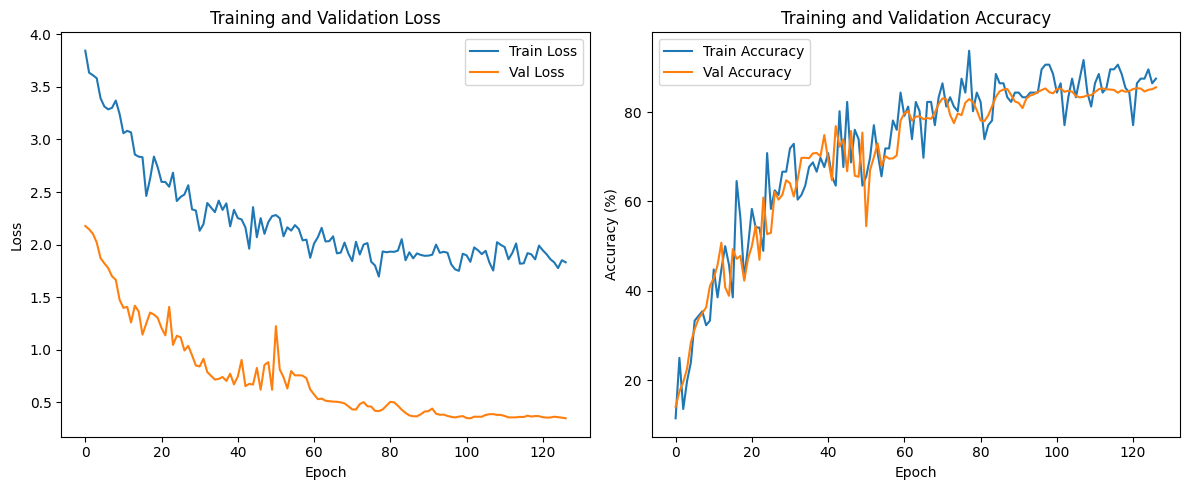

<ipython-input-6-c2218c61bc75>:722: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cdan_model.pth'))



Evaluating on validation set:


Evaluating: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s]


Classification Report:
                            precision    recall  f1-score   support

                   Healthy       0.52      1.00      0.68        80
Motor_1_Steady_state_error       0.97      0.74      0.84        80
             Motor_1_Stuck       0.98      0.99      0.98        80
Motor_2_Steady_state_error       0.86      0.75      0.80        80
             Motor_2_Stuck       0.96      0.95      0.96        80
Motor_3_Steady_state_error       0.79      0.61      0.69        80
             Motor_3_Stuck       0.93      0.97      0.95        80
Motor_4_Steady_state_error       0.59      0.33      0.42        80
             Motor_4_Stuck       0.86      0.91      0.88        80

                  accuracy                           0.81       720
                 macro avg       0.83      0.81      0.80       720
              weighted avg       0.83      0.81      0.80       720



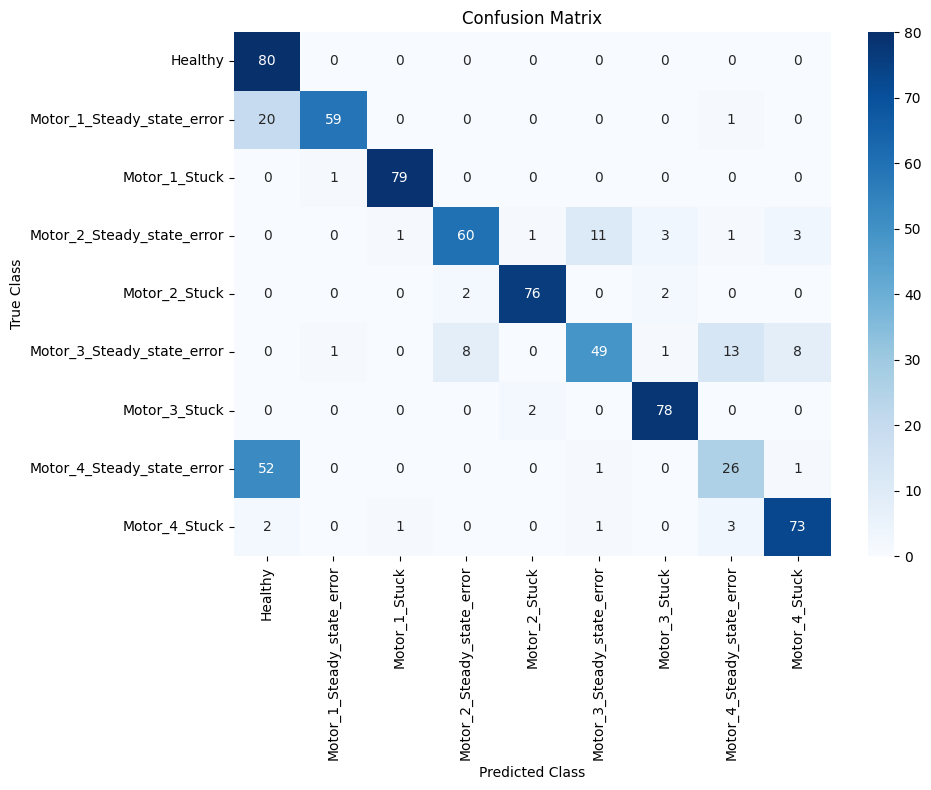

Accuracy: 0.8056
Weighted F1 Score: 0.8004


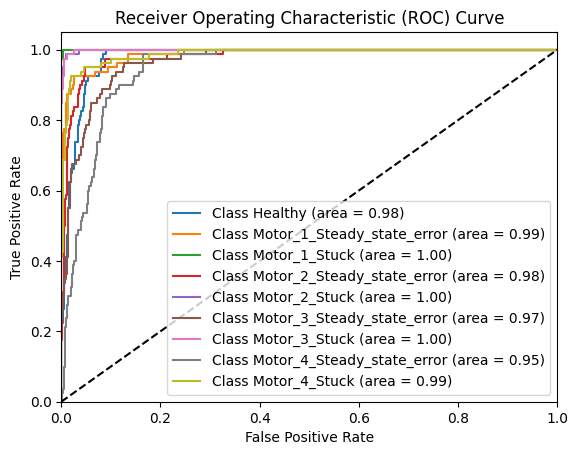


Evaluating on target domain:


Evaluating: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Classification Report:
                            precision    recall  f1-score   support

                   Healthy       0.44      0.40      0.42        10
Motor_1_Steady_state_error       0.88      0.70      0.78        10
             Motor_1_Stuck       0.53      0.80      0.64        10
Motor_2_Steady_state_error       0.67      0.80      0.73        10
             Motor_2_Stuck       1.00      0.90      0.95        10
Motor_3_Steady_state_error       0.50      0.60      0.55        10
             Motor_3_Stuck       0.83      1.00      0.91        10
Motor_4_Steady_state_error       0.33      0.10      0.15        10
             Motor_4_Stuck       0.70      0.70      0.70        10

                  accuracy                           0.67        90
                 macro avg       0.65      0.67      0.65        90
              weighted avg       0.65      0.67      0.65        90



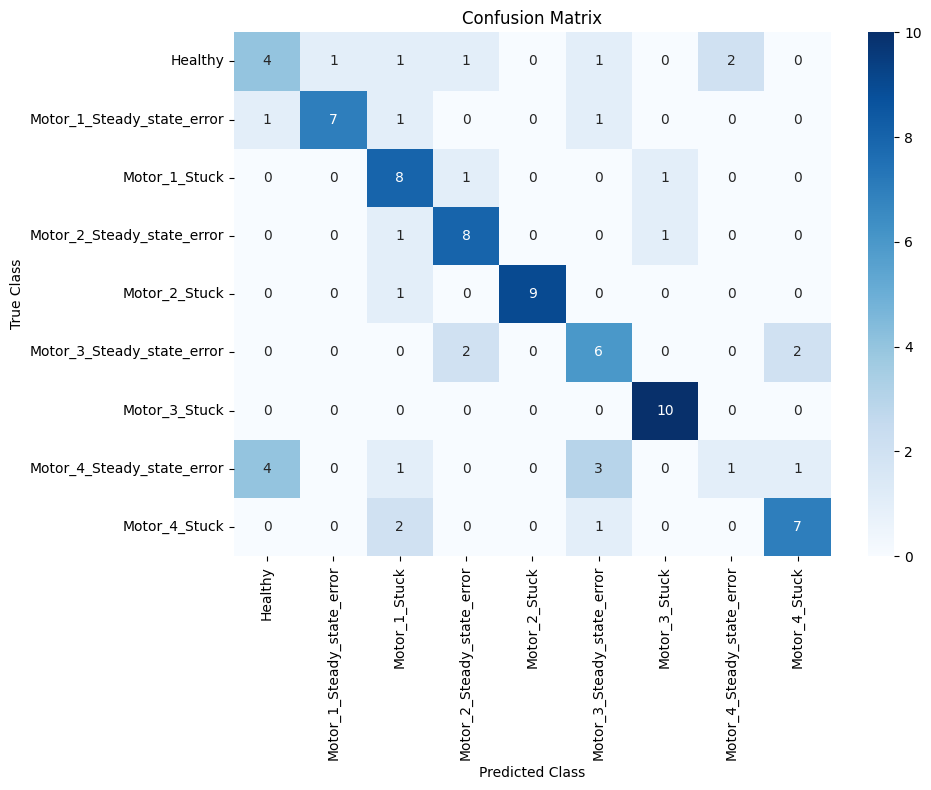

Accuracy: 0.6667
Weighted F1 Score: 0.6469


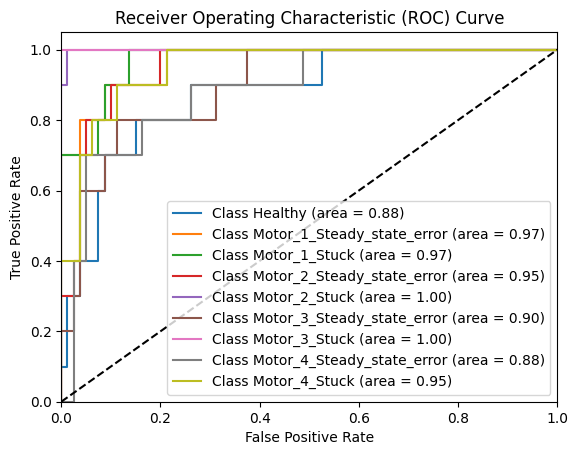


Performance Comparison:
Validation Set - Accuracy: 0.8056, F1 Score: 0.8004
Target Domain  - Accuracy: 0.6667, F1 Score: 0.6469


KeyboardInterrupt: 

In [6]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import torchviz

import matplotlib.pyplot as plt
import seaborn as sns
import logging
np.random.seed(40)
torch.manual_seed(40)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("cdan_training.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

#####################################################################
###### Data Loading and Preprocessing ###############################
####################################################################
def load_and_preprocess_data(source_path, target_path=None):
    # Load source domain data
    data = pd.read_csv(source_path)
    data = data.drop(['matFilePath'], axis=1)  # Remove irrelevant columns

    ################ FeatureEng ###########################################################################
    data['Residual-x'] = data['DesiredTrajectory-x'] - data['RealizedTrajectory-x']
    data['Residual-y'] = data['DesiredTrajectory-y'] - data['RealizedTrajectory-y']
    data['Residual-z'] = data['DesiredTrajectory-z'] - data['RealizedTrajectory-z']
    
    feature_cols = [
        'Motor1Cmd', 'Motor2Cmd', 'Motor3Cmd', 'Motor4Cmd',
        'DesiredTrajectory-x', 'DesiredTrajectory-y', 'DesiredTrajectory-z',
        'RealizedTrajectory-x', 'RealizedTrajectory-y', 'RealizedTrajectory-z',
        'Residual-x', 'Residual-y', 'Residual-z'
    ]
    
    ##########################################################################################################
    
    
    # Extracting features and target label
    X = data[feature_cols]
    y = data['Target']
    timestamps = data['Timestamps'] #just for indexing
    
    # Normalization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # One-hot encode the target
    encoder = OneHotEncoder(sparse_output=False) #previous, sparse=
    y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))
    
    # Build sequences
    sequences = []
    labels = []
    current_sequence = []
    current_labels = []
    
    for i in range(len(X_scaled)):
        current_sequence.append(X_scaled[i])
        current_labels.append(y.iloc[i])
        if i < len(X_scaled) - 1 and timestamps.iloc[i + 1] == 0.0:
            sequences.append(current_sequence)
            labels.append(current_labels[-1])  # Use the last label of the sequence
            current_sequence = []
            current_labels = []
    
    # Add the last sequence (range from 0.0 to 9.99) if it exists
    if current_sequence:
        sequences.append(current_sequence)
        labels.append(current_labels[-1])
    
    # Determine the maximum sequence length
    sequence_length = max(len(seq) for seq in sequences)
    num_features = X.shape[1]
    
    # Pad sequences to have the same length (if seq < range(0.00 to 9.99))
    padded_sequences = []
    for seq in sequences:
        if len(seq) < sequence_length:
            padding = [[0] * num_features] * (sequence_length - len(seq))
            seq.extend(padding)
        padded_sequences.append(seq)
    
    X_padded = np.array(padded_sequences)
    y_array = np.array(labels)
    
    # One-hot encode labels
    y_encoded = encoder.transform(y_array.reshape(-1, 1))
    
    # Split into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_padded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    # Create PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)
    
    # Create TensorDatasets and DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Feature Engineering and Process target domain data
    if target_path:
        target_data = pd.read_csv(target_path)
        # feature eng: computing residual cols
        target_data['Residual-x'] = target_data['DesiredTrajectory-x'] - target_data['RealizedTrajectory-x']
        target_data['Residual-y'] = target_data['DesiredTrajectory-y'] - target_data['RealizedTrajectory-y']
        target_data['Residual-z'] = target_data['DesiredTrajectory-z'] - target_data['RealizedTrajectory-z']
        X_target = target_data[feature_cols]
        y_target = target_data['Target']
        timestamps_target = target_data['Timestamps']
        
        # Use the same scaler as source domain
        X_target_scaled = scaler.transform(X_target)
        
        # Build sequences for target domain
        target_sequences = []
        target_labels = []
        current_sequence = []
        current_labels = []
        
        for i in range(len(X_target_scaled)):
            current_sequence.append(X_target_scaled[i])
            current_labels.append(y_target.iloc[i])
            if i < len(X_target_scaled) - 1 and timestamps_target.iloc[i + 1] == 0.0:
                target_sequences.append(current_sequence)
                target_labels.append(current_labels[-1])
                current_sequence = []
                current_labels = []
        
        if current_sequence:
            target_sequences.append(current_sequence)
            target_labels.append(current_labels[-1])
        
        # Pad target sequences, just as before..
        padded_target_sequences = []
        for seq in target_sequences:
            if len(seq) < sequence_length:
                padding = [[0] * num_features] * (sequence_length - len(seq))
                seq.extend(padding)
            padded_target_sequences.append(seq)
        
        X_target_padded = np.array(padded_target_sequences)
        y_target_array = np.array(target_labels)
        
        # One-hot encode target labels using the same encoder...
        y_target_encoded = encoder.transform(y_target_array.reshape(-1, 1))
        
        # Create tensors for target domain...
        X_target_tensor = torch.FloatTensor(X_target_padded).to(device)
        y_target_tensor = torch.FloatTensor(y_target_encoded).to(device)
        
        # Create dataset and dataloader for target domain..
        target_dataset = TensorDataset(X_target_tensor, y_target_tensor)
        target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True)
        
        return {
            'train_loader': train_loader,
            'val_loader': val_loader,
            'target_loader': target_loader,
            'sequence_length': sequence_length,
            'num_features': num_features,
            'num_classes': y_encoded.shape[1],
            'scaler': scaler,
            'encoder': encoder,
            'X_train_tensor': X_train_tensor,
            'y_train_tensor': y_train_tensor,
            'X_val_tensor': X_val_tensor,
            'y_val_tensor': y_val_tensor,
            'X_target_tensor': X_target_tensor,
            'y_target_tensor': y_target_tensor
        }
    
    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'sequence_length': sequence_length,
        'num_features': num_features,
        'num_classes': y_encoded.shape[1],
        'scaler': scaler,
        'encoder': encoder,
        'X_train_tensor': X_train_tensor,
        'y_train_tensor': y_train_tensor,
        'X_val_tensor': X_val_tensor,
        'y_val_tensor': y_val_tensor
    }

#################################################
#### Feature Extractor - Transformer Encoder ####
#################################################
class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=256):
        super(LearnablePositionalEncoding, self).__init__()
        self.pos_embedding = nn.Embedding(max_len, d_model)
        self.max_len = max_len

    def forward(self, x):
        # x shape: [batch_size, seq_length, d_model]
        batch_size, seq_length, _ = x.size()
        positions = torch.arange(0, seq_length, device=x.device).unsqueeze(0).expand(batch_size, seq_length)
        return x + self.pos_embedding(positions)


class FeatureExtractor(nn.Module):
    def __init__(self, input_size, hidden_size, max_len, num_heads=8, num_layers=6, dropout=0.1):
        super(FeatureExtractor, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.Dropout(dropout)
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_size))
        self.pos_encoder = LearnablePositionalEncoding(hidden_size, max_len+1)

        # Transformer encoder layers with residual connections
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=hidden_size,
                nhead=num_heads,
                dim_feedforward=hidden_size*4,
                dropout=dropout,
                batch_first=True,
                activation='gelu'
            ) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(hidden_size)
        self.batch_norm = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = self.embedding(x)
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = self.pos_encoder(x)

        # Apply transformer encoder layers with residual connections: self-attention mechanisms to capture dependencies between different positions in the input sequenc
        for layer in self.encoder_layers:
            x = layer(x) + x  # Residual connection

        x = self.layer_norm(x)
        features = x.mean(dim=1)  # Global pooling over sequence
        features = self.batch_norm(features)  # normalization
        return features


########################################
#### Label Predictor ###################
########################################
class LabelPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout=0.2):
        super(LabelPredictor, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

########################################
# Domain Classifier ####################
########################################
class DomainClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(DomainClassifier, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout)
        )

        # Skip Connection
        self.shortcut = nn.Linear(input_size, hidden_size // 4)

        # Binary Output with Sigmoid Activation
        self.output = nn.Linear(hidden_size // 4, 1)  

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)

        # Skip Connection
        x_shortcut = self.shortcut(x)
        x_final = x3 + x_shortcut  

        return self.output(x_final)  # Binary Output
        
################################################
# Gradient Reversal Layer for Domain Adaptation
################################################
class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class GradientReversal(nn.Module):
    def __init__(self, alpha=1.0):
        super(GradientReversal, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        return GradientReversalLayer.apply(x, self.alpha)

#####################
# CDAN Implementation
#####################
class CDAN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, max_len, num_heads=8, num_layers=4, dropout=0.2):
        super(CDAN, self).__init__()
        self.feature_extractor = FeatureExtractor(input_size, hidden_size, max_len, num_heads, num_layers, dropout)
        self.label_predictor = LabelPredictor(hidden_size, hidden_size//2, num_classes, dropout)
        
        # For the multilinear mapping in CDAN
        feature_out_dim = hidden_size
        class_out_dim = num_classes
        
        # Random matrix for multilinear map approximation
        self.randomized = True
        if self.randomized:
            self.random_matrix = torch.nn.Parameter(
                torch.randn(feature_out_dim * class_out_dim, hidden_size), requires_grad=False)
        
        # Domain classifier dimensions adjusted for randomized or not
        domain_input_dim = hidden_size
        self.domain_classifier = nn.Sequential(
            GradientReversal(),
            nn.Linear(domain_input_dim, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size//2, hidden_size//4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size//4, 1)  # Removed sigmoid for BCEWithLogitsLoss
        )

    def forward(self, x, alpha=1.0):
        features = self.feature_extractor(x)
        class_output = self.label_predictor(features)
        class_probabilities = F.softmax(class_output, dim=1)
        
        # For domain adaptation
        if self.training:
            # Update gradient reversal layer alpha
            for layer in self.domain_classifier:
                if isinstance(layer, GradientReversal):
                    layer.alpha = alpha
            
            # Multilinear map (tensor product)
            if self.randomized:
                # Approximation with random projection
                softmax_output = class_probabilities
                op_out = torch.bmm(softmax_output.unsqueeze(2), features.unsqueeze(1))
                op_out = op_out.view(-1, softmax_output.size(1) * features.size(1))
                domain_input = torch.mm(op_out, self.random_matrix)
            else:
                # Direct tensor product
                softmax_output = class_probabilities
                domain_input = torch.bmm(softmax_output.unsqueeze(2), features.unsqueezalphae(1))
                domain_input = domain_input.view(-1, softmax_output.size(1) * features.size(1))
            
            domain_output = self.domain_classifier(domain_input)
            return class_output, domain_output
        
        return class_output, None

#####################
# Training Function
#####################
def train_cdan(model, source_loader, target_loader, criterion, optimizer, scheduler, num_epochs=30, early_stopping_patience=5):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_loss = float('inf')
    epochs_no_improve = 0

    scaler = GradScaler()  # For mixed precision training
    
    # Domain loss with logits (safe for autocast)
    domain_criterion = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        # Calculate adaptive factor for gradient reversal
        p = epoch / num_epochs
        #alpha = 2. / (1. + np.exp(-10 * p)) - 1
        alpha = 2. / (1. + np.exp(-5 * p)) - 1
        # Training phase
        model.train()
        running_loss = 0.0
        running_cls_loss = 0.0
        running_domain_loss = 0.0
        correct = 0
        total = 0
        
        source_iter = iter(source_loader)
        target_iter = iter(target_loader)
        num_batches = min(len(source_loader), len(target_loader))
        
        for _ in tqdm(range(num_batches), desc=f"Epoch {epoch+1} Training"):
            # Source data
            try:
                source_data, source_labels = next(source_iter)
            except StopIteration:
                source_iter = iter(source_loader)
                source_data, source_labels = next(source_iter)
            
            # Target data
            try:
                target_data, _ = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                target_data, _ = next(target_iter)
            
            source_data, source_labels = source_data.to(device), source_labels.to(device)
            target_data = target_data.to(device)
            source_domain_labels = torch.ones(source_data.size(0), 1).to(device)
            target_domain_labels = torch.zeros(target_data.size(0), 1).to(device)
            
            optimizer.zero_grad()
            
            with autocast():  # Mixed precision
                # Forward pass for source domain
                class_outputs, domain_outputs = model(source_data, alpha)
                
                # Convert one-hot encoded labels to class indices
                source_label_indices = torch.max(source_labels, 1)[1]
                
                # Calculate classification loss
                cls_loss = criterion(class_outputs, source_label_indices)
                
                # Forward pass for target domain
                _, target_domain_outputs = model(target_data, alpha)
                
                # Calculate domain classification loss using BCEWithLogitsLoss
                domain_loss = domain_criterion(domain_outputs, source_domain_labels) + \
                             domain_criterion(target_domain_outputs, target_domain_labels)
                
                # Total loss
                loss = cls_loss + domain_loss
            
            # Backward pass and optimize with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # Statistics
            running_loss += loss.item()
            running_cls_loss += cls_loss.item()
            running_domain_loss += domain_loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(class_outputs.data, 1)
            total += source_label_indices.size(0)
            correct += (predicted == source_label_indices).sum().item()
        
        train_loss = running_loss / num_batches
        train_cls_loss = running_cls_loss / num_batches
        train_domain_loss = running_domain_loss / num_batches
        train_acc = 100 * correct / total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, labels in tqdm(source_loader, desc=f"Epoch {epoch+1} Validation"):
                data, labels = data.to(device), labels.to(device)
                label_indices = torch.max(labels, 1)[1]
                
                outputs, _ = model(data)
                loss = criterion(outputs, label_indices)
                
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += label_indices.size(0)
                correct += (predicted == label_indices).sum().item()
        
        avg_val_loss = val_loss / len(source_loader)
        val_acc = 100 * correct / total
        
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        
        # Update learning rate scheduler
        scheduler.step(avg_val_loss)
        
        # Print statistics
        info_str = (f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} (Class: {train_cls_loss:.4f}, Domain: {train_domain_loss:.4f}), "
                    f"Train Acc: {train_acc:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        logger.info(info_str)
        print(info_str)
        
        # Early stopping check
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_cdan_model.pth')
            logger.info("Best model saved.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= early_stopping_patience:
            logger.info("Early stopping triggered.")
            break
    
    return model, history

#####################
# Evaluation
#####################
def evaluate_model(model, test_loader, encoder):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in tqdm(test_loader, desc="Evaluating"):
            data, labels = data.to(device), labels.to(device)
            outputs, _ = model(data)

            # Convert outputs to predicted class
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())

            # Convert one-hot encoded labels to class indices
            label_indices = torch.max(labels, 1)[1]
            all_labels.extend(label_indices.cpu().numpy())

            # Get probabilities for ROC AUC
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)

    # Compute metrics
    cm = confusion_matrix(all_labels, all_preds)
    class_names = encoder.categories_[0]

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    plt.close()

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"Weighted F1 Score: {f1:.4f}")

    # Calculate ROC AUC
    all_probs = np.array(all_probs)
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    plt.close()

    return acc, f1


#####################
# Plots
#####################
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Training and Validation Loss")
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title("Training and Validation Accuracy")
    
    plt.tight_layout()
    plt.show()
    plt.close()



data_info = load_and_preprocess_data(
    source_path='/kaggle/input/dataset/combined_data.csv',
    target_path='/kaggle/input/dataset/combined_testing_data.csv'
)


# Model hyperparams
input_size = data_info['num_features']
hidden_size = 256
num_classes = data_info['num_classes']
max_len = data_info['sequence_length']
num_heads = 16 # Make sure hidden_size is divisible by num_heads
num_layers = 15

# Initialize CDAN model
model = CDAN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_classes=num_classes,
    max_len=max_len,
    num_heads=num_heads,
    num_layers=num_layers
).to(device)


# Wrapping the model with DataParallel just if running multiple GPUs
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=4, factor=0.5, verbose=True
)

# Model training
model, history = train_cdan(
    model=model,
    source_loader=data_info['train_loader'],
    target_loader=data_info['target_loader'],
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=200,
    early_stopping_patience=25
)

# Plot learning curves
plot_learning_curves(history)

# Loading best model for eval
model.load_state_dict(torch.load('best_cdan_model.pth'))

# Evaluate on validation set (real test data)
print("\nEvaluating on validation set:")
val_acc, val_f1 = evaluate_model(
    model=model,
    test_loader=data_info['val_loader'],
    encoder=data_info['encoder']
)

# on target domain
print("\nEvaluating on target domain:")
target_acc, target_f1 = evaluate_model(
    model=model,
    test_loader=data_info['target_loader'],
    encoder=data_info['encoder']
)

# Comparing results
print("\nPerformance Comparison:")
print(f"Validation Set - Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}")
print(f"Target Domain  - Accuracy: {target_acc:.4f}, F1 Score: {target_f1:.4f}")


# architecture diagram #
from torchviz import make_dot
x = torch.randn(1, max_len, input_size).to(device)
y, _ = model(x)
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render("cdan_model_architecture", format="png")


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-3-62b4c2db5c8c>:423: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training
Epoch 1 Training:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-3-62b4c2db5c8c>:467: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
Epoch 1 Validation:   0%|          | 0/90 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.li

Epoch 1: Train Loss: 3.7148 (Class: 2.1921, Domain: 1.5227), Train Acc: 13.54%, Val Loss: 2.1637, Val Acc: 16.01%


Epoch 2 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.90it/s]


Epoch 2: Train Loss: 3.6674 (Class: 2.1426, Domain: 1.5247), Train Acc: 25.00%, Val Loss: 2.1338, Val Acc: 17.05%


Epoch 3 Validation: 100%|██████████| 90/90 [00:49<00:00,  1.81it/s]


Epoch 3: Train Loss: 3.8052 (Class: 2.1624, Domain: 1.6427), Train Acc: 19.79%, Val Loss: 2.0850, Val Acc: 19.90%


Epoch 4 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.84it/s]


Epoch 4: Train Loss: 3.5933 (Class: 2.0330, Domain: 1.5604), Train Acc: 23.96%, Val Loss: 2.0263, Val Acc: 22.53%


Epoch 5 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.84it/s]


Epoch 5: Train Loss: 3.3924 (Class: 1.8513, Domain: 1.5411), Train Acc: 28.12%, Val Loss: 1.8846, Val Acc: 28.37%


Epoch 6 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.85it/s]


Epoch 6: Train Loss: 3.3928 (Class: 1.8576, Domain: 1.5353), Train Acc: 34.38%, Val Loss: 1.7919, Val Acc: 30.66%


Epoch 7 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.85it/s]


Epoch 7: Train Loss: 3.3480 (Class: 1.8037, Domain: 1.5443), Train Acc: 26.04%, Val Loss: 1.7052, Val Acc: 34.83%


Epoch 8 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.85it/s]


Epoch 8: Train Loss: 3.2006 (Class: 1.6966, Domain: 1.5040), Train Acc: 41.67%, Val Loss: 1.5818, Val Acc: 39.76%


Epoch 9 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.85it/s]


Epoch 9: Train Loss: 3.1740 (Class: 1.6495, Domain: 1.5245), Train Acc: 38.54%, Val Loss: 1.5154, Val Acc: 41.67%


Epoch 10 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.86it/s]


Epoch 10: Train Loss: 3.3285 (Class: 1.6665, Domain: 1.6620), Train Acc: 36.46%, Val Loss: 1.4683, Val Acc: 43.61%


Epoch 11 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.86it/s]


Epoch 11: Train Loss: 3.0017 (Class: 1.4177, Domain: 1.5840), Train Acc: 47.92%, Val Loss: 1.5161, Val Acc: 42.22%


Epoch 12 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.86it/s]


Epoch 12: Train Loss: 3.1471 (Class: 1.5274, Domain: 1.6197), Train Acc: 40.62%, Val Loss: 1.4121, Val Acc: 42.53%


Epoch 13 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.86it/s]


Epoch 13: Train Loss: 2.9372 (Class: 1.4230, Domain: 1.5141), Train Acc: 39.58%, Val Loss: 1.2499, Val Acc: 51.08%


Epoch 14 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 14: Train Loss: 2.8794 (Class: 1.3100, Domain: 1.5695), Train Acc: 54.17%, Val Loss: 1.2347, Val Acc: 51.88%


Epoch 15 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 15: Train Loss: 2.8828 (Class: 1.2502, Domain: 1.6326), Train Acc: 46.88%, Val Loss: 1.4745, Val Acc: 42.88%


Epoch 16 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.86it/s]


Epoch 16: Train Loss: 2.8579 (Class: 1.2934, Domain: 1.5644), Train Acc: 52.08%, Val Loss: 1.3364, Val Acc: 47.15%


Epoch 17 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 17: Train Loss: 2.8214 (Class: 1.1918, Domain: 1.6297), Train Acc: 50.00%, Val Loss: 1.1657, Val Acc: 48.82%


Epoch 18 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 18: Train Loss: 2.7414 (Class: 1.1444, Domain: 1.5971), Train Acc: 57.29%, Val Loss: 1.1603, Val Acc: 51.01%


Epoch 19 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 19: Train Loss: 2.9269 (Class: 1.2966, Domain: 1.6303), Train Acc: 48.96%, Val Loss: 1.1090, Val Acc: 52.19%


Epoch 20 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 20: Train Loss: 2.8264 (Class: 1.1689, Domain: 1.6575), Train Acc: 55.21%, Val Loss: 1.0873, Val Acc: 55.94%


Epoch 21 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 21: Train Loss: 2.6947 (Class: 1.1631, Domain: 1.5316), Train Acc: 55.21%, Val Loss: 1.1648, Val Acc: 52.64%


Epoch 22 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 22: Train Loss: 2.5530 (Class: 0.9535, Domain: 1.5995), Train Acc: 58.33%, Val Loss: 1.2577, Val Acc: 50.00%


Epoch 23 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 23: Train Loss: 2.5091 (Class: 0.9967, Domain: 1.5123), Train Acc: 51.04%, Val Loss: 1.0584, Val Acc: 58.58%


Epoch 24 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 24: Train Loss: 2.4655 (Class: 1.0208, Domain: 1.4447), Train Acc: 60.42%, Val Loss: 1.5778, Val Acc: 43.54%


Epoch 25 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 25: Train Loss: 2.5787 (Class: 1.1021, Domain: 1.4766), Train Acc: 57.29%, Val Loss: 1.2024, Val Acc: 51.84%


Epoch 26 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 26: Train Loss: 2.6735 (Class: 1.2028, Domain: 1.4707), Train Acc: 46.88%, Val Loss: 1.3464, Val Acc: 45.83%


Epoch 27 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 27: Train Loss: 2.5304 (Class: 1.0376, Domain: 1.4928), Train Acc: 60.42%, Val Loss: 1.2476, Val Acc: 47.36%


Epoch 28 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 28: Train Loss: 2.5380 (Class: 1.0903, Domain: 1.4477), Train Acc: 55.21%, Val Loss: 1.0023, Val Acc: 57.85%


Epoch 29 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 29: Train Loss: 2.4128 (Class: 0.9347, Domain: 1.4781), Train Acc: 62.50%, Val Loss: 1.0279, Val Acc: 58.82%


Epoch 30 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 30: Train Loss: 2.6277 (Class: 1.1975, Domain: 1.4302), Train Acc: 47.92%, Val Loss: 0.9555, Val Acc: 62.40%


Epoch 31 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 31: Train Loss: 2.4765 (Class: 0.9517, Domain: 1.5248), Train Acc: 62.50%, Val Loss: 1.1021, Val Acc: 58.85%


Epoch 32 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 32: Train Loss: 2.3262 (Class: 0.8550, Domain: 1.4712), Train Acc: 64.58%, Val Loss: 1.2868, Val Acc: 54.93%


Epoch 33 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 33: Train Loss: 2.6187 (Class: 1.1346, Domain: 1.4841), Train Acc: 59.38%, Val Loss: 0.9944, Val Acc: 60.03%


Epoch 34 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 34: Train Loss: 2.5170 (Class: 1.0325, Domain: 1.4846), Train Acc: 62.50%, Val Loss: 0.8479, Val Acc: 63.96%


Epoch 35 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 35: Train Loss: 2.3996 (Class: 0.8371, Domain: 1.5625), Train Acc: 71.88%, Val Loss: 0.9762, Val Acc: 60.35%


Epoch 36 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 36: Train Loss: 2.4176 (Class: 0.9139, Domain: 1.5038), Train Acc: 63.54%, Val Loss: 0.8751, Val Acc: 67.81%


Epoch 37 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 37: Train Loss: 2.3831 (Class: 0.9302, Domain: 1.4529), Train Acc: 65.62%, Val Loss: 0.9425, Val Acc: 62.50%


Epoch 38 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 38: Train Loss: 2.4683 (Class: 1.0133, Domain: 1.4550), Train Acc: 57.29%, Val Loss: 1.1097, Val Acc: 56.18%


Epoch 39 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 39: Train Loss: 2.3980 (Class: 0.9525, Domain: 1.4455), Train Acc: 66.67%, Val Loss: 1.2140, Val Acc: 52.01%


Epoch 40 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 40: Train Loss: 2.6016 (Class: 1.1758, Domain: 1.4258), Train Acc: 58.33%, Val Loss: 1.0037, Val Acc: 59.38%


Epoch 41 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 41: Train Loss: 2.2765 (Class: 0.8125, Domain: 1.4641), Train Acc: 71.88%, Val Loss: 0.9995, Val Acc: 58.85%


Epoch 42 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 42: Train Loss: 2.4434 (Class: 0.9848, Domain: 1.4587), Train Acc: 55.21%, Val Loss: 0.7779, Val Acc: 66.15%


Epoch 43 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 43: Train Loss: 2.1533 (Class: 0.7482, Domain: 1.4051), Train Acc: 64.58%, Val Loss: 0.7747, Val Acc: 65.87%


Epoch 44 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.89it/s]


Epoch 44: Train Loss: 2.1882 (Class: 0.7536, Domain: 1.4346), Train Acc: 64.58%, Val Loss: 0.8351, Val Acc: 65.42%


Epoch 45 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 45: Train Loss: 2.1851 (Class: 0.7567, Domain: 1.4285), Train Acc: 69.79%, Val Loss: 0.7411, Val Acc: 68.37%


Epoch 46 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 46: Train Loss: 2.1899 (Class: 0.7237, Domain: 1.4662), Train Acc: 67.71%, Val Loss: 0.6546, Val Acc: 72.78%


Epoch 47 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 47: Train Loss: 2.3727 (Class: 0.8761, Domain: 1.4965), Train Acc: 65.62%, Val Loss: 0.6470, Val Acc: 72.74%


Epoch 48 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 48: Train Loss: 2.1743 (Class: 0.7556, Domain: 1.4187), Train Acc: 69.79%, Val Loss: 0.7651, Val Acc: 70.49%


Epoch 49 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.89it/s]


Epoch 49: Train Loss: 2.1171 (Class: 0.6995, Domain: 1.4176), Train Acc: 68.75%, Val Loss: 0.7728, Val Acc: 67.08%


Epoch 50 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.89it/s]


Epoch 50: Train Loss: 2.2741 (Class: 0.8201, Domain: 1.4540), Train Acc: 65.62%, Val Loss: 0.7496, Val Acc: 66.18%


Epoch 51 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 51: Train Loss: 2.2786 (Class: 0.8554, Domain: 1.4232), Train Acc: 63.54%, Val Loss: 0.7062, Val Acc: 72.50%


Epoch 52 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 52: Train Loss: 2.0732 (Class: 0.6243, Domain: 1.4488), Train Acc: 79.17%, Val Loss: 0.6773, Val Acc: 72.33%


Epoch 53 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 53: Train Loss: 2.0013 (Class: 0.4988, Domain: 1.5024), Train Acc: 84.38%, Val Loss: 0.6669, Val Acc: 72.85%


Epoch 54 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 54: Train Loss: 2.1869 (Class: 0.7546, Domain: 1.4323), Train Acc: 71.88%, Val Loss: 0.6507, Val Acc: 74.31%


Epoch 55 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 55: Train Loss: 2.2147 (Class: 0.7462, Domain: 1.4686), Train Acc: 73.96%, Val Loss: 0.6268, Val Acc: 75.42%


Epoch 56 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 56: Train Loss: 2.1107 (Class: 0.6095, Domain: 1.5012), Train Acc: 81.25%, Val Loss: 0.5815, Val Acc: 76.39%


Epoch 57 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 57: Train Loss: 2.1843 (Class: 0.7497, Domain: 1.4346), Train Acc: 76.04%, Val Loss: 0.6157, Val Acc: 74.48%


Epoch 58 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 58: Train Loss: 2.0619 (Class: 0.6534, Domain: 1.4085), Train Acc: 70.83%, Val Loss: 0.7034, Val Acc: 71.22%


Epoch 59 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 59: Train Loss: 2.1304 (Class: 0.6960, Domain: 1.4344), Train Acc: 69.79%, Val Loss: 0.6473, Val Acc: 73.23%


Epoch 60 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 60: Train Loss: 1.9487 (Class: 0.4935, Domain: 1.4553), Train Acc: 85.42%, Val Loss: 0.5143, Val Acc: 80.45%


Epoch 61 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 61: Train Loss: 2.1604 (Class: 0.6723, Domain: 1.4882), Train Acc: 78.12%, Val Loss: 0.5002, Val Acc: 81.53%


Epoch 62 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 62: Train Loss: 2.1644 (Class: 0.6600, Domain: 1.5044), Train Acc: 77.08%, Val Loss: 0.4892, Val Acc: 82.01%


Epoch 63 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 63: Train Loss: 2.2614 (Class: 0.7929, Domain: 1.4685), Train Acc: 68.75%, Val Loss: 0.5157, Val Acc: 79.06%


Epoch 64 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 64: Train Loss: 2.0306 (Class: 0.5460, Domain: 1.4847), Train Acc: 80.21%, Val Loss: 0.4967, Val Acc: 79.69%


Epoch 65 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 65: Train Loss: 2.1712 (Class: 0.6474, Domain: 1.5237), Train Acc: 78.12%, Val Loss: 0.4346, Val Acc: 84.06%


Epoch 66 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 66: Train Loss: 2.0987 (Class: 0.6155, Domain: 1.4832), Train Acc: 73.96%, Val Loss: 0.4294, Val Acc: 84.83%


Epoch 67 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 67: Train Loss: 1.9822 (Class: 0.4574, Domain: 1.5248), Train Acc: 86.46%, Val Loss: 0.4143, Val Acc: 85.45%


Epoch 68 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 68: Train Loss: 2.1233 (Class: 0.6054, Domain: 1.5179), Train Acc: 76.04%, Val Loss: 0.4952, Val Acc: 80.24%


Epoch 69 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 69: Train Loss: 2.0387 (Class: 0.5492, Domain: 1.4895), Train Acc: 79.17%, Val Loss: 0.5528, Val Acc: 76.46%


Epoch 70 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 70: Train Loss: 1.9309 (Class: 0.4531, Domain: 1.4778), Train Acc: 81.25%, Val Loss: 0.4353, Val Acc: 82.26%


Epoch 71 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 71: Train Loss: 1.9243 (Class: 0.4317, Domain: 1.4926), Train Acc: 85.42%, Val Loss: 0.3820, Val Acc: 85.73%


Epoch 72 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 72: Train Loss: 2.0847 (Class: 0.6189, Domain: 1.4659), Train Acc: 80.21%, Val Loss: 0.4525, Val Acc: 82.64%


Epoch 73 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 73: Train Loss: 1.9442 (Class: 0.4423, Domain: 1.5019), Train Acc: 84.38%, Val Loss: 0.6125, Val Acc: 76.22%


Epoch 74 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 74: Train Loss: 2.0800 (Class: 0.5922, Domain: 1.4878), Train Acc: 78.12%, Val Loss: 0.5821, Val Acc: 76.60%


Epoch 75 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 75: Train Loss: 2.1039 (Class: 0.6083, Domain: 1.4956), Train Acc: 76.04%, Val Loss: 0.4987, Val Acc: 81.42%


Epoch 76 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 76: Train Loss: 1.8720 (Class: 0.3995, Domain: 1.4725), Train Acc: 84.38%, Val Loss: 0.4540, Val Acc: 82.40%


Epoch 77 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 77: Train Loss: 1.8610 (Class: 0.3606, Domain: 1.5003), Train Acc: 90.62%, Val Loss: 0.4176, Val Acc: 83.99%


Epoch 78 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 78: Train Loss: 1.7938 (Class: 0.3388, Domain: 1.4550), Train Acc: 91.67%, Val Loss: 0.4224, Val Acc: 84.06%


Epoch 79 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 79: Train Loss: 2.0195 (Class: 0.5322, Domain: 1.4872), Train Acc: 78.12%, Val Loss: 0.4274, Val Acc: 83.99%


Epoch 80 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 80: Train Loss: 1.8992 (Class: 0.4338, Domain: 1.4654), Train Acc: 87.50%, Val Loss: 0.4607, Val Acc: 82.15%


Epoch 81 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 81: Train Loss: 1.9336 (Class: 0.4598, Domain: 1.4738), Train Acc: 82.29%, Val Loss: 0.5375, Val Acc: 78.85%


Epoch 82 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 82: Train Loss: 1.9564 (Class: 0.4770, Domain: 1.4793), Train Acc: 82.29%, Val Loss: 0.4956, Val Acc: 80.56%


Epoch 83 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 83: Train Loss: 2.0233 (Class: 0.5018, Domain: 1.5215), Train Acc: 81.25%, Val Loss: 0.4062, Val Acc: 83.75%


Epoch 84 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 84: Train Loss: 1.9514 (Class: 0.4812, Domain: 1.4702), Train Acc: 85.42%, Val Loss: 0.3638, Val Acc: 85.83%


Epoch 85 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 85: Train Loss: 1.9012 (Class: 0.4033, Domain: 1.4979), Train Acc: 82.29%, Val Loss: 0.3468, Val Acc: 86.77%


Epoch 86 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 86: Train Loss: 1.9454 (Class: 0.4678, Domain: 1.4776), Train Acc: 86.46%, Val Loss: 0.3408, Val Acc: 87.36%


Epoch 87 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 87: Train Loss: 1.8772 (Class: 0.3713, Domain: 1.5059), Train Acc: 86.46%, Val Loss: 0.3747, Val Acc: 85.42%


Epoch 88 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 88: Train Loss: 1.8397 (Class: 0.3409, Domain: 1.4989), Train Acc: 88.54%, Val Loss: 0.4015, Val Acc: 84.24%


Epoch 89 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 89: Train Loss: 1.8888 (Class: 0.4164, Domain: 1.4724), Train Acc: 86.46%, Val Loss: 0.4475, Val Acc: 82.64%


Epoch 90 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 90: Train Loss: 1.8451 (Class: 0.3414, Domain: 1.5037), Train Acc: 90.62%, Val Loss: 0.4585, Val Acc: 82.19%


Epoch 91 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 91: Train Loss: 1.9574 (Class: 0.4323, Domain: 1.5251), Train Acc: 82.29%, Val Loss: 0.4114, Val Acc: 83.75%


Epoch 92 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 92: Train Loss: 1.9118 (Class: 0.4207, Domain: 1.4911), Train Acc: 85.42%, Val Loss: 0.4110, Val Acc: 83.72%


Epoch 93 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 93: Train Loss: 1.9368 (Class: 0.4167, Domain: 1.5201), Train Acc: 85.42%, Val Loss: 0.3787, Val Acc: 85.03%


Epoch 94 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 94: Train Loss: 1.8225 (Class: 0.3372, Domain: 1.4853), Train Acc: 87.50%, Val Loss: 0.3581, Val Acc: 85.80%


Epoch 95 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 95: Train Loss: 1.8936 (Class: 0.3523, Domain: 1.5412), Train Acc: 83.33%, Val Loss: 0.3514, Val Acc: 86.46%


Epoch 96 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 96: Train Loss: 1.8579 (Class: 0.3618, Domain: 1.4961), Train Acc: 86.46%, Val Loss: 0.3363, Val Acc: 87.12%


Epoch 97 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 97: Train Loss: 1.8766 (Class: 0.3449, Domain: 1.5317), Train Acc: 90.62%, Val Loss: 0.3352, Val Acc: 87.29%


Epoch 98 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 98: Train Loss: 1.8835 (Class: 0.3113, Domain: 1.5722), Train Acc: 90.62%, Val Loss: 0.3429, Val Acc: 86.70%


Epoch 99 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 99: Train Loss: 1.9218 (Class: 0.3658, Domain: 1.5560), Train Acc: 86.46%, Val Loss: 0.3521, Val Acc: 86.32%


Epoch 100 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 100: Train Loss: 1.8869 (Class: 0.3818, Domain: 1.5052), Train Acc: 90.62%, Val Loss: 0.3726, Val Acc: 85.49%


Epoch 101 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 101: Train Loss: 1.9385 (Class: 0.3846, Domain: 1.5538), Train Acc: 84.38%, Val Loss: 0.3647, Val Acc: 85.45%


Epoch 102 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 102: Train Loss: 1.9282 (Class: 0.4203, Domain: 1.5079), Train Acc: 83.33%, Val Loss: 0.3614, Val Acc: 85.90%


Epoch 103 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 103: Train Loss: 2.0166 (Class: 0.5258, Domain: 1.4908), Train Acc: 79.17%, Val Loss: 0.3821, Val Acc: 85.14%


Epoch 104 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 104: Train Loss: 1.9450 (Class: 0.4235, Domain: 1.5215), Train Acc: 86.46%, Val Loss: 0.3821, Val Acc: 85.21%


Epoch 105 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 105: Train Loss: 1.8118 (Class: 0.3300, Domain: 1.4817), Train Acc: 88.54%, Val Loss: 0.3605, Val Acc: 85.90%


Epoch 106 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 106: Train Loss: 1.9892 (Class: 0.4745, Domain: 1.5147), Train Acc: 81.25%, Val Loss: 0.3574, Val Acc: 85.94%


Epoch 107 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 107: Train Loss: 1.8976 (Class: 0.3862, Domain: 1.5114), Train Acc: 85.42%, Val Loss: 0.3594, Val Acc: 86.01%


Epoch 108 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 108: Train Loss: 1.8769 (Class: 0.3313, Domain: 1.5456), Train Acc: 88.54%, Val Loss: 0.3600, Val Acc: 86.08%


Epoch 109 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 109: Train Loss: 1.9295 (Class: 0.4133, Domain: 1.5162), Train Acc: 86.46%, Val Loss: 0.3606, Val Acc: 86.01%


Epoch 110 Validation: 100%|██████████| 90/90 [00:48<00:00,  1.87it/s]


Epoch 110: Train Loss: 1.9108 (Class: 0.4373, Domain: 1.4735), Train Acc: 85.42%, Val Loss: 0.3585, Val Acc: 86.15%


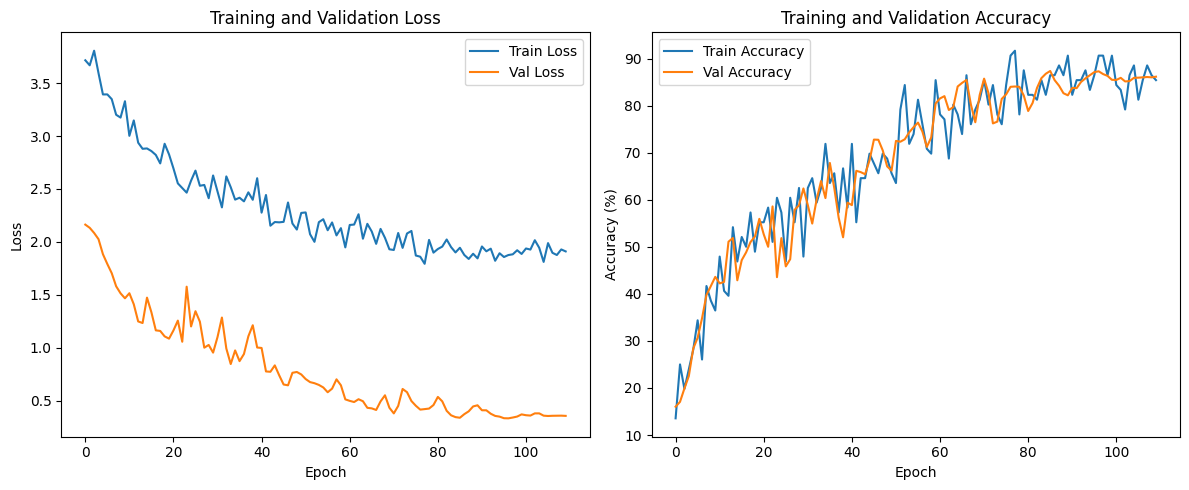

<ipython-input-3-62b4c2db5c8c>:722: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cdan_model.pth'))



Evaluating on validation set:


Evaluating: 100%|██████████| 23/23 [00:12<00:00,  1.92it/s]


Classification Report:
                            precision    recall  f1-score   support

                   Healthy       0.60      0.97      0.75        80
Motor_1_Steady_state_error       0.90      0.76      0.82        80
             Motor_1_Stuck       0.99      0.96      0.97        80
Motor_2_Steady_state_error       0.85      0.75      0.79        80
             Motor_2_Stuck       0.99      0.95      0.97        80
Motor_3_Steady_state_error       0.80      0.69      0.74        80
             Motor_3_Stuck       0.94      0.99      0.96        80
Motor_4_Steady_state_error       0.78      0.53      0.63        80
             Motor_4_Stuck       0.79      0.89      0.84        80

                  accuracy                           0.83       720
                 macro avg       0.85      0.83      0.83       720
              weighted avg       0.85      0.83      0.83       720



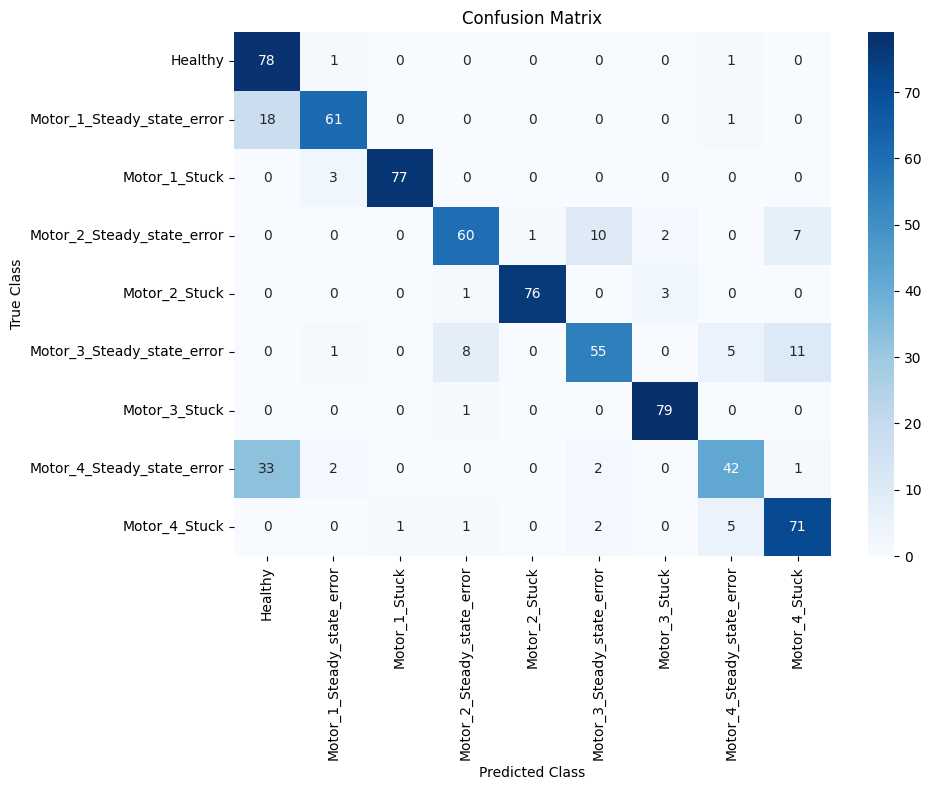

Accuracy: 0.8319
Weighted F1 Score: 0.8302


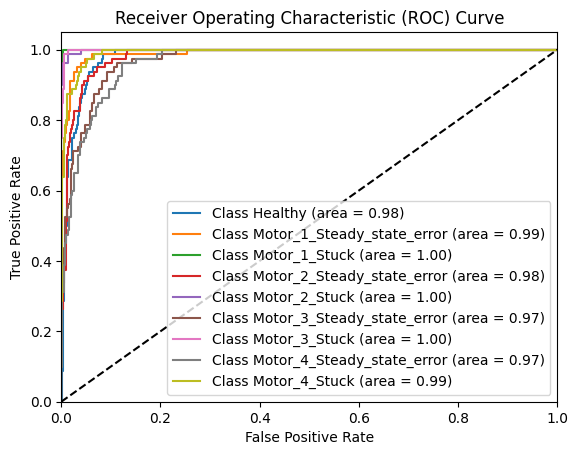


Evaluating on target domain:


Evaluating: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


Classification Report:
                            precision    recall  f1-score   support

                   Healthy       0.50      0.40      0.44        10
Motor_1_Steady_state_error       0.45      0.50      0.48        10
             Motor_1_Stuck       0.58      0.70      0.64        10
Motor_2_Steady_state_error       0.58      0.70      0.64        10
             Motor_2_Stuck       0.83      1.00      0.91        10
Motor_3_Steady_state_error       0.62      0.50      0.56        10
             Motor_3_Stuck       0.75      0.90      0.82        10
Motor_4_Steady_state_error       0.25      0.10      0.14        10
             Motor_4_Stuck       0.64      0.70      0.67        10

                  accuracy                           0.61        90
                 macro avg       0.58      0.61      0.59        90
              weighted avg       0.58      0.61      0.59        90



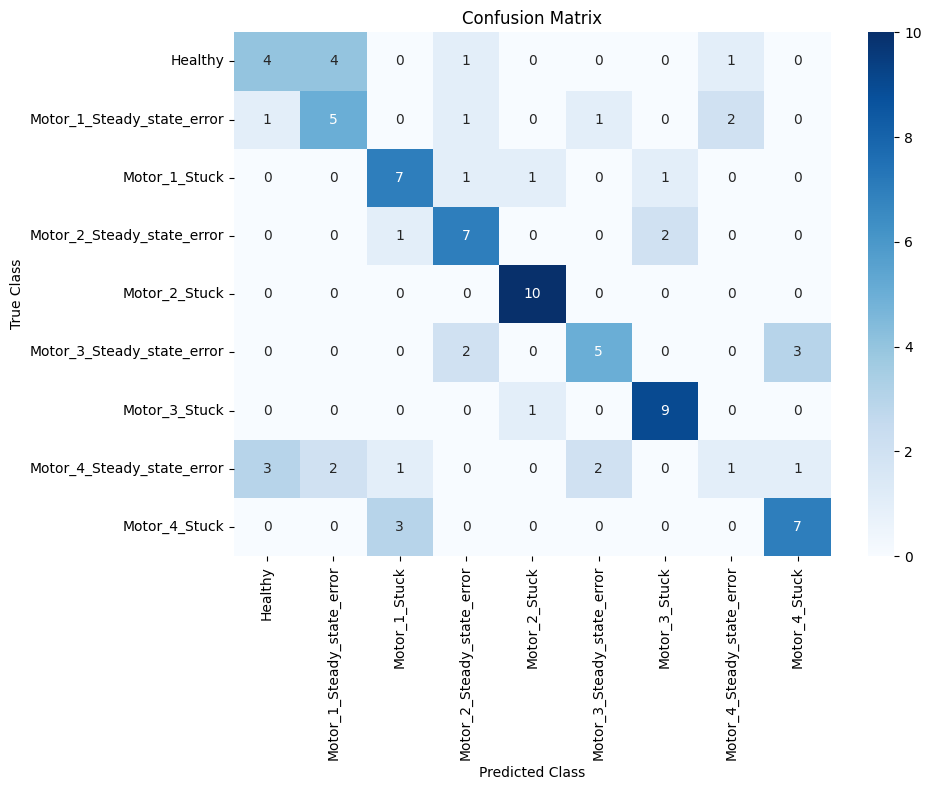

Accuracy: 0.6111
Weighted F1 Score: 0.5873


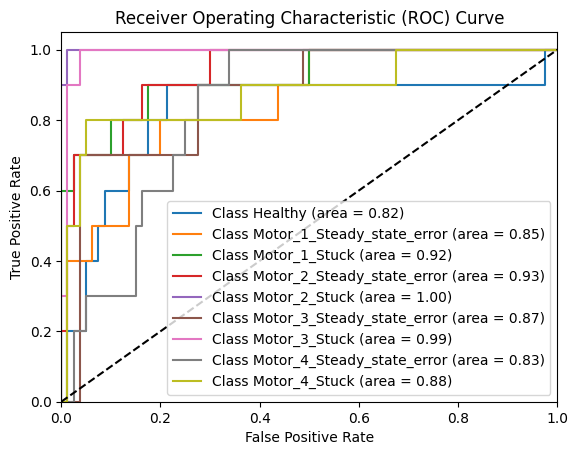


Performance Comparison:
Validation Set - Accuracy: 0.8319, F1 Score: 0.8302
Target Domain  - Accuracy: 0.6111, F1 Score: 0.5873


'# architecture diagram #\nfrom torchviz import make_dot\nx = torch.randn(1, max_len, input_size).to(device)\ny, _ = model(x)\ndot = make_dot(y, params=dict(model.named_parameters()))\ndot.render("cdan_model_architecture", format="png")\n'

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
#import torchviz

import matplotlib.pyplot as plt
import seaborn as sns
import logging
np.random.seed(40)
torch.manual_seed(40)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("cdan_training.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

#####################################################################
###### Data Loading and Preprocessing ###############################
####################################################################
def load_and_preprocess_data(source_path, target_path=None):
    # Load source domain data
    data = pd.read_csv(source_path)
    data = data.drop(['matFilePath'], axis=1)  # Remove irrelevant columns

    ################ FeatureEng ###########################################################################
    data['Residual-x'] = data['DesiredTrajectory-x'] - data['RealizedTrajectory-x']
    data['Residual-y'] = data['DesiredTrajectory-y'] - data['RealizedTrajectory-y']
    data['Residual-z'] = data['DesiredTrajectory-z'] - data['RealizedTrajectory-z']
    
    feature_cols = [
        'Motor1Cmd', 'Motor2Cmd', 'Motor3Cmd', 'Motor4Cmd',
        'DesiredTrajectory-x', 'DesiredTrajectory-y', 'DesiredTrajectory-z',
        'RealizedTrajectory-x', 'RealizedTrajectory-y', 'RealizedTrajectory-z',
        'Residual-x', 'Residual-y', 'Residual-z'
    ]
    
    ##########################################################################################################
    
    
    # Extracting features and target label
    X = data[feature_cols]
    y = data['Target']
    timestamps = data['Timestamps'] #just for indexing
    
    # Normalization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # One-hot encode the target
    encoder = OneHotEncoder(sparse_output=False) #previous, sparse=
    y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))
    
    # Build sequences
    sequences = []
    labels = []
    current_sequence = []
    current_labels = []
    
    for i in range(len(X_scaled)):
        current_sequence.append(X_scaled[i])
        current_labels.append(y.iloc[i])
        if i < len(X_scaled) - 1 and timestamps.iloc[i + 1] == 0.0:
            sequences.append(current_sequence)
            labels.append(current_labels[-1])  # Use the last label of the sequence
            current_sequence = []
            current_labels = []
    
    # Add the last sequence (range from 0.0 to 9.99) if it exists
    if current_sequence:
        sequences.append(current_sequence)
        labels.append(current_labels[-1])
    
    # Determine the maximum sequence length
    sequence_length = max(len(seq) for seq in sequences)
    num_features = X.shape[1]
    
    # Pad sequences to have the same length (if seq < range(0.00 to 9.99))
    padded_sequences = []
    for seq in sequences:
        if len(seq) < sequence_length:
            padding = [[0] * num_features] * (sequence_length - len(seq))
            seq.extend(padding)
        padded_sequences.append(seq)
    
    X_padded = np.array(padded_sequences)
    y_array = np.array(labels)
    
    # One-hot encode labels
    y_encoded = encoder.transform(y_array.reshape(-1, 1))
    
    # Split into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_padded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    # Create PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)
    
    # Create TensorDatasets and DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Feature Engineering and Process target domain data
    if target_path:
        target_data = pd.read_csv(target_path)
        # feature eng: computing residual cols
        target_data['Residual-x'] = target_data['DesiredTrajectory-x'] - target_data['RealizedTrajectory-x']
        target_data['Residual-y'] = target_data['DesiredTrajectory-y'] - target_data['RealizedTrajectory-y']
        target_data['Residual-z'] = target_data['DesiredTrajectory-z'] - target_data['RealizedTrajectory-z']
        X_target = target_data[feature_cols]
        y_target = target_data['Target']
        timestamps_target = target_data['Timestamps']
        
        # Use the same scaler as source domain
        X_target_scaled = scaler.transform(X_target)
        
        # Build sequences for target domain
        target_sequences = []
        target_labels = []
        current_sequence = []
        current_labels = []
        
        for i in range(len(X_target_scaled)):
            current_sequence.append(X_target_scaled[i])
            current_labels.append(y_target.iloc[i])
            if i < len(X_target_scaled) - 1 and timestamps_target.iloc[i + 1] == 0.0:
                target_sequences.append(current_sequence)
                target_labels.append(current_labels[-1])
                current_sequence = []
                current_labels = []
        
        if current_sequence:
            target_sequences.append(current_sequence)
            target_labels.append(current_labels[-1])
        
        # Pad target sequences, just as before..
        padded_target_sequences = []
        for seq in target_sequences:
            if len(seq) < sequence_length:
                padding = [[0] * num_features] * (sequence_length - len(seq))
                seq.extend(padding)
            padded_target_sequences.append(seq)
        
        X_target_padded = np.array(padded_target_sequences)
        y_target_array = np.array(target_labels)
        
        # One-hot encode target labels using the same encoder...
        y_target_encoded = encoder.transform(y_target_array.reshape(-1, 1))
        
        # Create tensors for target domain...
        X_target_tensor = torch.FloatTensor(X_target_padded).to(device)
        y_target_tensor = torch.FloatTensor(y_target_encoded).to(device)
        
        # Create dataset and dataloader for target domain..
        target_dataset = TensorDataset(X_target_tensor, y_target_tensor)
        target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True)
        
        return {
            'train_loader': train_loader,
            'val_loader': val_loader,
            'target_loader': target_loader,
            'sequence_length': sequence_length,
            'num_features': num_features,
            'num_classes': y_encoded.shape[1],
            'scaler': scaler,
            'encoder': encoder,
            'X_train_tensor': X_train_tensor,
            'y_train_tensor': y_train_tensor,
            'X_val_tensor': X_val_tensor,
            'y_val_tensor': y_val_tensor,
            'X_target_tensor': X_target_tensor,
            'y_target_tensor': y_target_tensor
        }
    
    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'sequence_length': sequence_length,
        'num_features': num_features,
        'num_classes': y_encoded.shape[1],
        'scaler': scaler,
        'encoder': encoder,
        'X_train_tensor': X_train_tensor,
        'y_train_tensor': y_train_tensor,
        'X_val_tensor': X_val_tensor,
        'y_val_tensor': y_val_tensor
    }

#################################################
#### Feature Extractor - Transformer Encoder ####
#################################################
class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=256):
        super(LearnablePositionalEncoding, self).__init__()
        self.pos_embedding = nn.Embedding(max_len, d_model)
        self.max_len = max_len

    def forward(self, x):
        # x shape: [batch_size, seq_length, d_model]
        batch_size, seq_length, _ = x.size()
        positions = torch.arange(0, seq_length, device=x.device).unsqueeze(0).expand(batch_size, seq_length)
        return x + self.pos_embedding(positions)


class FeatureExtractor(nn.Module):
    def __init__(self, input_size, hidden_size, max_len, num_heads=8, num_layers=6, dropout=0.1):
        super(FeatureExtractor, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.Dropout(dropout)
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_size))
        self.pos_encoder = LearnablePositionalEncoding(hidden_size, max_len+1)

        # Transformer encoder layers with residual connections
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=hidden_size,
                nhead=num_heads,
                dim_feedforward=hidden_size*4,
                dropout=dropout,
                batch_first=True,
                activation='gelu'
            ) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(hidden_size)
        self.batch_norm = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = self.embedding(x)
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = self.pos_encoder(x)

        # Apply transformer encoder layers with residual connections: self-attention mechanisms to capture dependencies between different positions in the input sequenc
        for layer in self.encoder_layers:
            x = layer(x) + x  # Residual connection

        x = self.layer_norm(x)
        features = x.mean(dim=1)  # Global pooling over sequence
        features = self.batch_norm(features)  # normalization
        return features


########################################
#### Label Predictor ###################
########################################
class LabelPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout=0.2):
        super(LabelPredictor, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

########################################
# Domain Classifier ####################
########################################
class DomainClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(DomainClassifier, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout)
        )

        # Skip Connection
        self.shortcut = nn.Linear(input_size, hidden_size // 4)

        # Binary Output with Sigmoid Activation
        self.output = nn.Linear(hidden_size // 4, 1)  

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)

        # Skip Connection
        x_shortcut = self.shortcut(x)
        x_final = x3 + x_shortcut  

        return self.output(x_final)  # Binary Output
        
###################################################
### Gradient Reversal Layer for Domain Adaptation #
###################################################
class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class GradientReversal(nn.Module):
    def __init__(self, alpha=1.0):
        super(GradientReversal, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        return GradientReversalLayer.apply(x, self.alpha)

#####################
# CDAN Implementation
#####################
class CDAN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, max_len, num_heads=8, num_layers=4, dropout=0.2):
        super(CDAN, self).__init__()
        self.feature_extractor = FeatureExtractor(input_size, hidden_size, max_len, num_heads, num_layers, dropout)
        self.label_predictor = LabelPredictor(hidden_size, hidden_size//2, num_classes, dropout)
        
        # For the multilinear mapping in CDAN
        feature_out_dim = hidden_size
        class_out_dim = num_classes
        
        # Random matrix for multilinear map approximation
        self.randomized = True
        if self.randomized:
            self.random_matrix = torch.nn.Parameter(
                torch.randn(feature_out_dim * class_out_dim, hidden_size), requires_grad=False)
        
        # Domain classifier dimensions adjusted for randomized or not
        domain_input_dim = hidden_size
        self.domain_classifier = nn.Sequential(
            GradientReversal(),
            nn.Linear(domain_input_dim, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size//2, hidden_size//4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size//4, 1)  # Removed sigmoid for BCEWithLogitsLoss
        )

    def forward(self, x, alpha=1.0):
        features = self.feature_extractor(x)
        class_output = self.label_predictor(features)
        class_probabilities = F.softmax(class_output, dim=1)
        
        # For domain adaptation
        if self.training:
            # Update gradient reversal layer alpha
            for layer in self.domain_classifier:
                if isinstance(layer, GradientReversal):
                    layer.alpha = alpha
            
            # Multilinear map (tensor product)
            if self.randomized:
                # Approximation with random projection
                softmax_output = class_probabilities
                op_out = torch.bmm(softmax_output.unsqueeze(2), features.unsqueeze(1))
                op_out = op_out.view(-1, softmax_output.size(1) * features.size(1))
                domain_input = torch.mm(op_out, self.random_matrix)
            else:
                # Direct tensor product
                softmax_output = class_probabilities
                domain_input = torch.bmm(softmax_output.unsqueeze(2), features.unsqueezalphae(1))
                domain_input = domain_input.view(-1, softmax_output.size(1) * features.size(1))
            
            domain_output = self.domain_classifier(domain_input)
            return class_output, domain_output
        
        return class_output, None

#####################
# Training Function
#####################
def train_cdan(model, source_loader, target_loader, criterion, optimizer, scheduler, num_epochs=30, early_stopping_patience=5):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_loss = float('inf')
    epochs_no_improve = 0

    scaler = GradScaler()  # For mixed precision training
    
    # Domain loss with logits (safe for autocast)
    domain_criterion = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        # Calculate adaptive factor for gradient reversal
        p = epoch / num_epochs
        #alpha = 2. / (1. + np.exp(-10 * p)) - 1
        alpha = 2. / (1. + np.exp(-5 * p)) - 1
        # Training phase
        model.train()
        running_loss = 0.0
        running_cls_loss = 0.0
        running_domain_loss = 0.0
        correct = 0
        total = 0
        
        source_iter = iter(source_loader)
        target_iter = iter(target_loader)
        num_batches = min(len(source_loader), len(target_loader))
        
        for _ in tqdm(range(num_batches), desc=f"Epoch {epoch+1} Training"):
            # Source data
            try:
                source_data, source_labels = next(source_iter)
            except StopIteration:
                source_iter = iter(source_loader)
                source_data, source_labels = next(source_iter)
            
            # Target data
            try:
                target_data, _ = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                target_data, _ = next(target_iter)
            
            source_data, source_labels = source_data.to(device), source_labels.to(device)
            target_data = target_data.to(device)
            source_domain_labels = torch.ones(source_data.size(0), 1).to(device)
            target_domain_labels = torch.zeros(target_data.size(0), 1).to(device)
            
            optimizer.zero_grad()
            
            with autocast():  # Mixed precision
                # Forward pass for source domain
                class_outputs, domain_outputs = model(source_data, alpha)
                
                # Convert one-hot encoded labels to class indices
                source_label_indices = torch.max(source_labels, 1)[1]
                
                # Calculate classification loss
                cls_loss = criterion(class_outputs, source_label_indices)
                
                # Forward pass for target domain
                _, target_domain_outputs = model(target_data, alpha)
                
                # Calculate domain classification loss using BCEWithLogitsLoss
                domain_loss = domain_criterion(domain_outputs, source_domain_labels) + \
                             domain_criterion(target_domain_outputs, target_domain_labels)
                
                # Total loss
                loss = cls_loss + domain_loss
            
            # Backward pass and optimize with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # Statistics
            running_loss += loss.item()
            running_cls_loss += cls_loss.item()
            running_domain_loss += domain_loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(class_outputs.data, 1)
            total += source_label_indices.size(0)
            correct += (predicted == source_label_indices).sum().item()
        
        train_loss = running_loss / num_batches
        train_cls_loss = running_cls_loss / num_batches
        train_domain_loss = running_domain_loss / num_batches
        train_acc = 100 * correct / total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, labels in tqdm(source_loader, desc=f"Epoch {epoch+1} Validation"):
                data, labels = data.to(device), labels.to(device)
                label_indices = torch.max(labels, 1)[1]
                
                outputs, _ = model(data)
                loss = criterion(outputs, label_indices)
                
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += label_indices.size(0)
                correct += (predicted == label_indices).sum().item()
        
        avg_val_loss = val_loss / len(source_loader)
        val_acc = 100 * correct / total
        
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        
        # Update learning rate scheduler
        scheduler.step(avg_val_loss)
        
        # Print statistics
        info_str = (f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} (Class: {train_cls_loss:.4f}, Domain: {train_domain_loss:.4f}), "
                    f"Train Acc: {train_acc:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        logger.info(info_str)
        print(info_str)
        
        # Early stopping check
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_cdan_model.pth')
            logger.info("Best model saved.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= early_stopping_patience:
            logger.info("Early stopping triggered.")
            break
    
    return model, history

#########################
##### Evaluation ########
#########################
def evaluate_model(model, test_loader, encoder):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in tqdm(test_loader, desc="Evaluating"):
            data, labels = data.to(device), labels.to(device)
            outputs, _ = model(data)

            # Convert outputs to predicted class
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())

            # Convert one-hot encoded labels to class indices
            label_indices = torch.max(labels, 1)[1]
            all_labels.extend(label_indices.cpu().numpy())

            # Get probabilities for ROC AUC
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)

    # Compute metrics
    cm = confusion_matrix(all_labels, all_preds)
    class_names = encoder.categories_[0]

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    plt.close()

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"Weighted F1 Score: {f1:.4f}")

    # Calculate ROC AUC
    all_probs = np.array(all_probs)
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    plt.close()

    return acc, f1


#####################
##### Plots #########
#####################
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Training and Validation Loss")
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title("Training and Validation Accuracy")
    
    plt.tight_layout()
    plt.show()
    plt.close()



data_info = load_and_preprocess_data(
    source_path='/kaggle/input/dataset/combined_data.csv',
    target_path='/kaggle/input/dataset/combined_testing_data.csv'
)


# Model hyperparams
input_size = data_info['num_features']
hidden_size = 256
num_classes = data_info['num_classes']
max_len = data_info['sequence_length']
num_heads = 32 # Make sure hidden_size is divisible by num_heads
num_layers = 15

# Initialize CDAN model
model = CDAN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_classes=num_classes,
    max_len=max_len,
    num_heads=num_heads,
    num_layers=num_layers
).to(device)


# Wrapping the model with DataParallel just if running multiple GPUs
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=4, factor=0.5, verbose=True
)

# Model training
model, history = train_cdan(
    model=model,
    source_loader=data_info['train_loader'],
    target_loader=data_info['target_loader'],
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=110,
    early_stopping_patience=25
)

# Plot learning curves
plot_learning_curves(history)

# Loading best model for eval
model.load_state_dict(torch.load('best_cdan_model.pth'))

# Evaluate on validation set (real test data)
print("\nEvaluating on validation set:")
val_acc, val_f1 = evaluate_model(
    model=model,
    test_loader=data_info['val_loader'],
    encoder=data_info['encoder']
)

# on target domain
print("\nEvaluating on target domain:")
target_acc, target_f1 = evaluate_model(
    model=model,
    test_loader=data_info['target_loader'],
    encoder=data_info['encoder']
)

# Comparing results
print("\nPerformance Comparison:")
print(f"Validation Set - Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}")
print(f"Target Domain  - Accuracy: {target_acc:.4f}, F1 Score: {target_f1:.4f}")


"""# architecture diagram #
from torchviz import make_dot
x = torch.randn(1, max_len, input_size).to(device)
y, _ = model(x)
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render("cdan_model_architecture", format="png")
"""

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-4-8af87037c20e>:423: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training
Epoch 1 Training:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-4-8af87037c20e>:467: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
Epoch 1 Validation:   0%|          | 0/90 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.li

Epoch 1: Train Loss: 3.7469 (Class: 2.2664, Domain: 1.4805), Train Acc: 10.42%, Val Loss: 2.1811, Val Acc: 15.80%


Epoch 2 Validation: 100%|██████████| 90/90 [00:31<00:00,  2.86it/s]


Epoch 2: Train Loss: 3.5962 (Class: 2.2077, Domain: 1.3885), Train Acc: 16.67%, Val Loss: 2.1579, Val Acc: 17.43%


Epoch 3 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 3: Train Loss: 3.5925 (Class: 2.1813, Domain: 1.4113), Train Acc: 19.79%, Val Loss: 2.1205, Val Acc: 20.17%


Epoch 4 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Epoch 4: Train Loss: 3.6302 (Class: 2.2041, Domain: 1.4261), Train Acc: 21.88%, Val Loss: 2.0485, Val Acc: 23.19%


Epoch 5 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.71it/s]


Epoch 5: Train Loss: 3.3985 (Class: 1.9663, Domain: 1.4322), Train Acc: 28.12%, Val Loss: 1.9681, Val Acc: 24.48%


Epoch 6 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.70it/s]


Epoch 6: Train Loss: 3.4570 (Class: 1.9594, Domain: 1.4976), Train Acc: 25.00%, Val Loss: 1.8852, Val Acc: 27.40%


Epoch 7 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.70it/s]


Epoch 7: Train Loss: 3.2596 (Class: 1.8390, Domain: 1.4206), Train Acc: 34.38%, Val Loss: 1.7689, Val Acc: 30.56%


Epoch 8 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.70it/s]


Epoch 8: Train Loss: 3.2665 (Class: 1.8363, Domain: 1.4302), Train Acc: 27.08%, Val Loss: 1.7028, Val Acc: 33.58%


Epoch 9 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.71it/s]


Epoch 9: Train Loss: 3.2157 (Class: 1.6613, Domain: 1.5544), Train Acc: 33.33%, Val Loss: 1.6095, Val Acc: 34.97%


Epoch 10 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.71it/s]


Epoch 10: Train Loss: 2.9934 (Class: 1.5546, Domain: 1.4389), Train Acc: 36.46%, Val Loss: 1.6252, Val Acc: 35.17%


Epoch 11 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.71it/s]


Epoch 11: Train Loss: 3.0725 (Class: 1.5318, Domain: 1.5407), Train Acc: 39.58%, Val Loss: 1.4803, Val Acc: 40.21%


Epoch 12 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.71it/s]


Epoch 12: Train Loss: 3.0651 (Class: 1.6070, Domain: 1.4580), Train Acc: 35.42%, Val Loss: 1.5132, Val Acc: 37.95%


Epoch 13 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.71it/s]


Epoch 13: Train Loss: 2.9531 (Class: 1.4084, Domain: 1.5447), Train Acc: 39.58%, Val Loss: 1.4140, Val Acc: 46.39%


Epoch 14 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.71it/s]


Epoch 14: Train Loss: 2.8444 (Class: 1.4720, Domain: 1.3723), Train Acc: 43.75%, Val Loss: 1.5957, Val Acc: 32.22%


Epoch 15 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.71it/s]


Epoch 15: Train Loss: 2.7448 (Class: 1.3366, Domain: 1.4082), Train Acc: 46.88%, Val Loss: 1.3441, Val Acc: 43.37%


Epoch 16 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.71it/s]


Epoch 16: Train Loss: 2.8975 (Class: 1.4337, Domain: 1.4639), Train Acc: 34.38%, Val Loss: 1.2956, Val Acc: 47.95%


Epoch 17 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.72it/s]


Epoch 17: Train Loss: 2.6570 (Class: 1.2249, Domain: 1.4321), Train Acc: 46.88%, Val Loss: 1.2838, Val Acc: 46.32%


Epoch 18 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.72it/s]


Epoch 18: Train Loss: 2.8194 (Class: 1.3707, Domain: 1.4487), Train Acc: 41.67%, Val Loss: 1.2708, Val Acc: 49.93%


Epoch 19 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.72it/s]


Epoch 19: Train Loss: 2.6669 (Class: 1.2278, Domain: 1.4391), Train Acc: 51.04%, Val Loss: 1.2591, Val Acc: 48.78%


Epoch 20 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.72it/s]


Epoch 20: Train Loss: 2.6280 (Class: 1.2056, Domain: 1.4224), Train Acc: 52.08%, Val Loss: 1.1127, Val Acc: 55.66%


Epoch 21 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.72it/s]


Epoch 21: Train Loss: 2.5643 (Class: 1.1394, Domain: 1.4249), Train Acc: 55.21%, Val Loss: 1.2925, Val Acc: 46.60%


Epoch 22 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.73it/s]


Epoch 22: Train Loss: 2.6307 (Class: 1.2369, Domain: 1.3938), Train Acc: 48.96%, Val Loss: 1.0568, Val Acc: 56.25%


Epoch 23 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.73it/s]


Epoch 23: Train Loss: 2.5059 (Class: 1.0643, Domain: 1.4416), Train Acc: 57.29%, Val Loss: 1.0985, Val Acc: 55.38%


Epoch 24 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.71it/s]


Epoch 24: Train Loss: 2.7437 (Class: 1.3525, Domain: 1.3912), Train Acc: 45.83%, Val Loss: 1.3614, Val Acc: 46.49%


Epoch 25 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.72it/s]


Epoch 25: Train Loss: 2.4797 (Class: 1.0606, Domain: 1.4191), Train Acc: 56.25%, Val Loss: 1.6699, Val Acc: 44.48%


Epoch 26 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.72it/s]


Epoch 26: Train Loss: 2.4755 (Class: 1.0683, Domain: 1.4072), Train Acc: 56.25%, Val Loss: 1.1490, Val Acc: 50.62%


Epoch 27 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.73it/s]


Epoch 27: Train Loss: 2.5425 (Class: 1.0590, Domain: 1.4835), Train Acc: 57.29%, Val Loss: 1.0474, Val Acc: 54.10%


Epoch 28 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.73it/s]


Epoch 28: Train Loss: 2.5909 (Class: 1.1399, Domain: 1.4510), Train Acc: 50.00%, Val Loss: 0.9534, Val Acc: 60.03%


Epoch 29 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.73it/s]


Epoch 29: Train Loss: 2.4713 (Class: 1.0914, Domain: 1.3799), Train Acc: 56.25%, Val Loss: 1.1319, Val Acc: 56.60%


Epoch 30 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.73it/s]


Epoch 30: Train Loss: 2.4043 (Class: 0.9931, Domain: 1.4112), Train Acc: 56.25%, Val Loss: 1.0813, Val Acc: 54.97%


Epoch 31 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.72it/s]


Epoch 31: Train Loss: 2.3174 (Class: 0.8643, Domain: 1.4531), Train Acc: 64.58%, Val Loss: 0.9202, Val Acc: 61.77%


Epoch 32 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.73it/s]


Epoch 32: Train Loss: 2.6078 (Class: 1.1079, Domain: 1.4999), Train Acc: 54.17%, Val Loss: 1.0650, Val Acc: 54.86%


Epoch 33 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.73it/s]


Epoch 33: Train Loss: 2.5108 (Class: 1.0917, Domain: 1.4191), Train Acc: 50.00%, Val Loss: 1.1214, Val Acc: 53.40%


Epoch 34 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.73it/s]


Epoch 34: Train Loss: 2.4200 (Class: 0.9928, Domain: 1.4272), Train Acc: 57.29%, Val Loss: 1.1710, Val Acc: 55.42%


Epoch 35 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 35: Train Loss: 2.4416 (Class: 0.9155, Domain: 1.5261), Train Acc: 66.67%, Val Loss: 0.9023, Val Acc: 64.83%


Epoch 36 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 36: Train Loss: 2.2415 (Class: 0.7806, Domain: 1.4608), Train Acc: 75.00%, Val Loss: 1.1230, Val Acc: 60.24%


Epoch 37 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 37: Train Loss: 2.5107 (Class: 1.0935, Domain: 1.4173), Train Acc: 55.21%, Val Loss: 0.8929, Val Acc: 65.35%


Epoch 38 Validation: 100%|██████████| 90/90 [00:33<00:00,  2.72it/s]


Epoch 38: Train Loss: 2.2206 (Class: 0.7633, Domain: 1.4573), Train Acc: 69.79%, Val Loss: 0.7944, Val Acc: 68.02%


Epoch 39 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 39: Train Loss: 2.1528 (Class: 0.6611, Domain: 1.4917), Train Acc: 68.75%, Val Loss: 0.7599, Val Acc: 69.86%


Epoch 40 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 40: Train Loss: 2.2439 (Class: 0.8374, Domain: 1.4065), Train Acc: 59.38%, Val Loss: 0.7566, Val Acc: 69.79%


Epoch 41 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 41: Train Loss: 2.2061 (Class: 0.8164, Domain: 1.3897), Train Acc: 63.54%, Val Loss: 0.9994, Val Acc: 61.01%


Epoch 42 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.73it/s]


Epoch 42: Train Loss: 2.2579 (Class: 0.8530, Domain: 1.4049), Train Acc: 65.62%, Val Loss: 0.9275, Val Acc: 62.78%


Epoch 43 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.73it/s]


Epoch 43: Train Loss: 2.1840 (Class: 0.7735, Domain: 1.4106), Train Acc: 71.88%, Val Loss: 0.8712, Val Acc: 65.14%


Epoch 44 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 44: Train Loss: 2.0749 (Class: 0.6874, Domain: 1.3876), Train Acc: 70.83%, Val Loss: 0.9941, Val Acc: 64.03%


Epoch 45 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.73it/s]


Epoch 45: Train Loss: 2.2576 (Class: 0.8367, Domain: 1.4209), Train Acc: 67.71%, Val Loss: 1.1961, Val Acc: 58.44%


Epoch 46 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 46: Train Loss: 2.2968 (Class: 0.9053, Domain: 1.3915), Train Acc: 61.46%, Val Loss: 0.7451, Val Acc: 69.86%


Epoch 47 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 47: Train Loss: 2.3448 (Class: 0.9158, Domain: 1.4291), Train Acc: 64.58%, Val Loss: 0.7551, Val Acc: 67.99%


Epoch 48 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 48: Train Loss: 2.1323 (Class: 0.7372, Domain: 1.3951), Train Acc: 76.04%, Val Loss: 0.7060, Val Acc: 70.62%


Epoch 49 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 49: Train Loss: 2.2482 (Class: 0.8610, Domain: 1.3872), Train Acc: 67.71%, Val Loss: 0.8640, Val Acc: 68.09%


Epoch 50 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 50: Train Loss: 2.1451 (Class: 0.7524, Domain: 1.3927), Train Acc: 75.00%, Val Loss: 0.7213, Val Acc: 71.88%


Epoch 51 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 51: Train Loss: 2.0704 (Class: 0.6715, Domain: 1.3989), Train Acc: 83.33%, Val Loss: 0.6636, Val Acc: 73.37%


Epoch 52 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 52: Train Loss: 2.1565 (Class: 0.7252, Domain: 1.4313), Train Acc: 70.83%, Val Loss: 0.6316, Val Acc: 75.31%


Epoch 53 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 53: Train Loss: 2.0194 (Class: 0.6373, Domain: 1.3821), Train Acc: 75.00%, Val Loss: 0.6002, Val Acc: 76.35%


Epoch 54 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 54: Train Loss: 2.1574 (Class: 0.7262, Domain: 1.4312), Train Acc: 72.92%, Val Loss: 0.6685, Val Acc: 75.49%


Epoch 55 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 55: Train Loss: 2.1421 (Class: 0.7300, Domain: 1.4120), Train Acc: 75.00%, Val Loss: 0.8362, Val Acc: 68.72%


Epoch 56 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 56: Train Loss: 2.2045 (Class: 0.7731, Domain: 1.4315), Train Acc: 69.79%, Val Loss: 0.6767, Val Acc: 73.99%


Epoch 57 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 57: Train Loss: 2.0523 (Class: 0.6551, Domain: 1.3972), Train Acc: 76.04%, Val Loss: 0.7256, Val Acc: 73.26%


Epoch 58 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 58: Train Loss: 1.9398 (Class: 0.5300, Domain: 1.4098), Train Acc: 83.33%, Val Loss: 0.8220, Val Acc: 66.01%


Epoch 59 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 59: Train Loss: 2.0700 (Class: 0.6324, Domain: 1.4376), Train Acc: 77.08%, Val Loss: 0.7396, Val Acc: 68.54%


Epoch 60 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 60: Train Loss: 2.1424 (Class: 0.7613, Domain: 1.3811), Train Acc: 69.79%, Val Loss: 0.5009, Val Acc: 80.87%


Epoch 61 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 61: Train Loss: 1.9104 (Class: 0.5032, Domain: 1.4073), Train Acc: 82.29%, Val Loss: 0.5024, Val Acc: 80.52%


Epoch 62 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 62: Train Loss: 2.0665 (Class: 0.6641, Domain: 1.4024), Train Acc: 73.96%, Val Loss: 0.5795, Val Acc: 78.16%


Epoch 63 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.75it/s]


Epoch 63: Train Loss: 1.9218 (Class: 0.5198, Domain: 1.4020), Train Acc: 81.25%, Val Loss: 0.5934, Val Acc: 78.06%


Epoch 64 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 64: Train Loss: 1.9589 (Class: 0.5656, Domain: 1.3934), Train Acc: 73.96%, Val Loss: 0.5335, Val Acc: 80.62%


Epoch 65 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 65: Train Loss: 1.8018 (Class: 0.3981, Domain: 1.4037), Train Acc: 86.46%, Val Loss: 0.4585, Val Acc: 82.78%


Epoch 66 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 66: Train Loss: 1.9076 (Class: 0.5331, Domain: 1.3745), Train Acc: 84.38%, Val Loss: 0.4268, Val Acc: 84.06%


Epoch 67 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 67: Train Loss: 1.9897 (Class: 0.5939, Domain: 1.3958), Train Acc: 75.00%, Val Loss: 0.4407, Val Acc: 83.51%


Epoch 68 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 68: Train Loss: 1.9040 (Class: 0.5022, Domain: 1.4017), Train Acc: 80.21%, Val Loss: 0.4783, Val Acc: 82.26%


Epoch 69 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 69: Train Loss: 1.8429 (Class: 0.4522, Domain: 1.3907), Train Acc: 79.17%, Val Loss: 0.5579, Val Acc: 78.85%


Epoch 70 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.75it/s]


Epoch 70: Train Loss: 1.8603 (Class: 0.4828, Domain: 1.3776), Train Acc: 80.21%, Val Loss: 0.5536, Val Acc: 79.38%


Epoch 71 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 71: Train Loss: 1.8485 (Class: 0.4755, Domain: 1.3730), Train Acc: 78.12%, Val Loss: 0.4585, Val Acc: 82.85%


Epoch 72 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 72: Train Loss: 1.8386 (Class: 0.4320, Domain: 1.4067), Train Acc: 82.29%, Val Loss: 0.4001, Val Acc: 84.79%


Epoch 73 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 73: Train Loss: 1.9540 (Class: 0.5336, Domain: 1.4203), Train Acc: 76.04%, Val Loss: 0.3566, Val Acc: 86.39%


Epoch 74 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 74: Train Loss: 1.7663 (Class: 0.3888, Domain: 1.3776), Train Acc: 84.38%, Val Loss: 0.3826, Val Acc: 84.38%


Epoch 75 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 75: Train Loss: 1.8920 (Class: 0.4771, Domain: 1.4149), Train Acc: 83.33%, Val Loss: 0.4346, Val Acc: 82.43%


Epoch 76 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 76: Train Loss: 1.9352 (Class: 0.5265, Domain: 1.4087), Train Acc: 77.08%, Val Loss: 0.4021, Val Acc: 84.06%


Epoch 77 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 77: Train Loss: 1.7815 (Class: 0.3987, Domain: 1.3828), Train Acc: 86.46%, Val Loss: 0.3493, Val Acc: 87.05%


Epoch 78 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 78: Train Loss: 1.8486 (Class: 0.4166, Domain: 1.4320), Train Acc: 84.38%, Val Loss: 0.3313, Val Acc: 88.30%


Epoch 79 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.73it/s]


Epoch 79: Train Loss: 1.8672 (Class: 0.4563, Domain: 1.4109), Train Acc: 82.29%, Val Loss: 0.3660, Val Acc: 86.53%


Epoch 80 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 80: Train Loss: 1.9098 (Class: 0.5081, Domain: 1.4017), Train Acc: 81.25%, Val Loss: 0.4394, Val Acc: 82.29%


Epoch 81 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 81: Train Loss: 1.7978 (Class: 0.3824, Domain: 1.4154), Train Acc: 82.29%, Val Loss: 0.5036, Val Acc: 78.96%


Epoch 82 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 82: Train Loss: 1.8016 (Class: 0.4019, Domain: 1.3997), Train Acc: 84.38%, Val Loss: 0.4803, Val Acc: 80.35%


Epoch 83 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 83: Train Loss: 1.7978 (Class: 0.3794, Domain: 1.4184), Train Acc: 87.50%, Val Loss: 0.4224, Val Acc: 82.81%


Epoch 84 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 84: Train Loss: 1.7465 (Class: 0.3205, Domain: 1.4260), Train Acc: 87.50%, Val Loss: 0.3929, Val Acc: 84.17%


Epoch 85 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 85: Train Loss: 1.7560 (Class: 0.3700, Domain: 1.3860), Train Acc: 85.42%, Val Loss: 0.3428, Val Acc: 86.77%


Epoch 86 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 86: Train Loss: 1.7617 (Class: 0.3655, Domain: 1.3961), Train Acc: 86.46%, Val Loss: 0.3341, Val Acc: 87.50%


Epoch 87 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 87: Train Loss: 1.7992 (Class: 0.3974, Domain: 1.4019), Train Acc: 84.38%, Val Loss: 0.3228, Val Acc: 87.92%


Epoch 88 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 88: Train Loss: 1.8136 (Class: 0.4551, Domain: 1.3585), Train Acc: 84.38%, Val Loss: 0.3191, Val Acc: 88.47%


Epoch 89 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.73it/s]


Epoch 89: Train Loss: 1.8182 (Class: 0.4346, Domain: 1.3836), Train Acc: 84.38%, Val Loss: 0.3270, Val Acc: 88.19%


Epoch 90 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 90: Train Loss: 1.9006 (Class: 0.5056, Domain: 1.3950), Train Acc: 80.21%, Val Loss: 0.3579, Val Acc: 86.74%


Epoch 91 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 91: Train Loss: 1.7734 (Class: 0.3750, Domain: 1.3984), Train Acc: 89.58%, Val Loss: 0.3885, Val Acc: 85.21%


Epoch 92 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.75it/s]


Epoch 92: Train Loss: 1.7022 (Class: 0.3233, Domain: 1.3789), Train Acc: 90.62%, Val Loss: 0.3641, Val Acc: 86.15%


Epoch 93 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.75it/s]


Epoch 93: Train Loss: 1.7934 (Class: 0.4058, Domain: 1.3876), Train Acc: 84.38%, Val Loss: 0.3598, Val Acc: 85.38%


Epoch 94 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 94: Train Loss: 1.6856 (Class: 0.2895, Domain: 1.3961), Train Acc: 92.71%, Val Loss: 0.3811, Val Acc: 84.31%


Epoch 95 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.73it/s]


Epoch 95: Train Loss: 1.8639 (Class: 0.4807, Domain: 1.3832), Train Acc: 82.29%, Val Loss: 0.3577, Val Acc: 85.21%


Epoch 96 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 96: Train Loss: 1.7187 (Class: 0.3109, Domain: 1.4078), Train Acc: 88.54%, Val Loss: 0.3631, Val Acc: 85.10%


Epoch 97 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 97: Train Loss: 1.8169 (Class: 0.4373, Domain: 1.3796), Train Acc: 85.42%, Val Loss: 0.3601, Val Acc: 85.35%


Epoch 98 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 98: Train Loss: 1.8592 (Class: 0.4707, Domain: 1.3886), Train Acc: 77.08%, Val Loss: 0.3799, Val Acc: 84.65%


Epoch 99 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 99: Train Loss: 1.6383 (Class: 0.2442, Domain: 1.3941), Train Acc: 92.71%, Val Loss: 0.3705, Val Acc: 84.86%


Epoch 100 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 100: Train Loss: 1.8146 (Class: 0.4030, Domain: 1.4116), Train Acc: 86.46%, Val Loss: 0.3620, Val Acc: 85.14%


Epoch 101 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.75it/s]


Epoch 101: Train Loss: 1.8177 (Class: 0.4317, Domain: 1.3860), Train Acc: 86.46%, Val Loss: 0.3680, Val Acc: 84.90%


Epoch 102 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.75it/s]


Epoch 102: Train Loss: 1.7509 (Class: 0.3388, Domain: 1.4121), Train Acc: 86.46%, Val Loss: 0.3766, Val Acc: 84.72%


Epoch 103 Validation: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Epoch 103: Train Loss: 1.7767 (Class: 0.3844, Domain: 1.3922), Train Acc: 82.29%, Val Loss: 0.3592, Val Acc: 85.56%


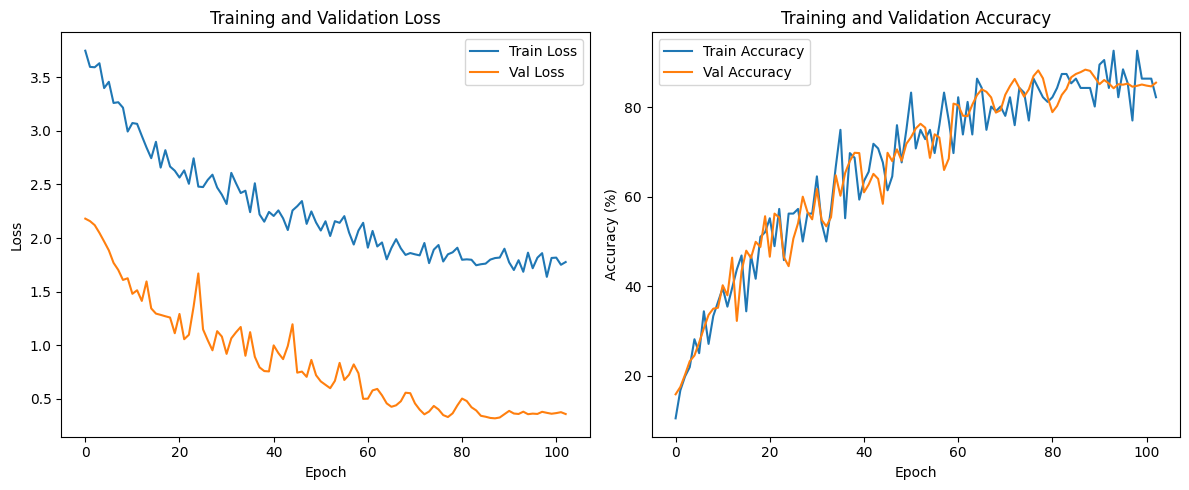

<ipython-input-4-8af87037c20e>:722: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cdan_model.pth'))



Evaluating on validation set:


Evaluating: 100%|██████████| 23/23 [00:08<00:00,  2.81it/s]


Classification Report:
                            precision    recall  f1-score   support

                   Healthy       0.59      0.89      0.71        80
Motor_1_Steady_state_error       0.93      0.80      0.86        80
             Motor_1_Stuck       0.96      0.99      0.98        80
Motor_2_Steady_state_error       0.78      0.80      0.79        80
             Motor_2_Stuck       0.99      0.95      0.97        80
Motor_3_Steady_state_error       0.79      0.65      0.71        80
             Motor_3_Stuck       0.94      0.96      0.95        80
Motor_4_Steady_state_error       0.68      0.54      0.60        80
             Motor_4_Stuck       0.89      0.88      0.88        80

                  accuracy                           0.83       720
                 macro avg       0.84      0.83      0.83       720
              weighted avg       0.84      0.83      0.83       720



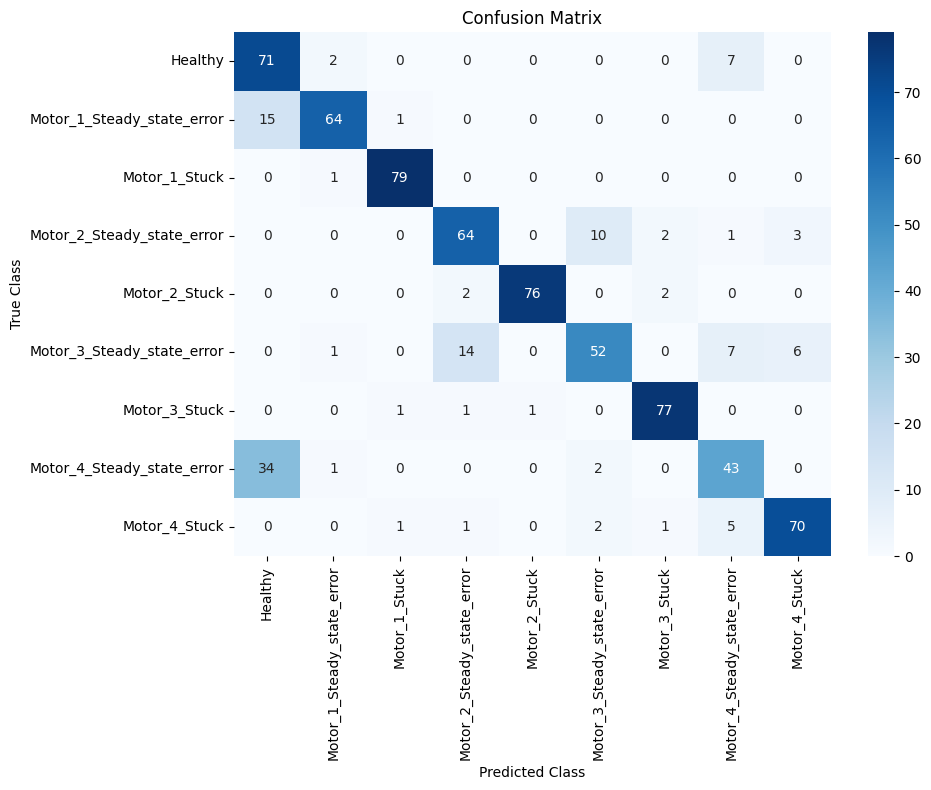

Accuracy: 0.8278
Weighted F1 Score: 0.8275


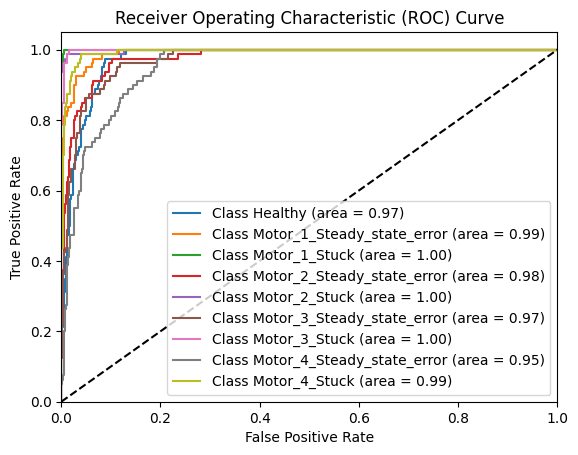


Evaluating on target domain:


Evaluating: 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


Classification Report:
                            precision    recall  f1-score   support

                   Healthy       0.33      0.30      0.32        10
Motor_1_Steady_state_error       0.70      0.70      0.70        10
             Motor_1_Stuck       0.67      0.80      0.73        10
Motor_2_Steady_state_error       0.55      0.60      0.57        10
             Motor_2_Stuck       1.00      1.00      1.00        10
Motor_3_Steady_state_error       0.64      0.70      0.67        10
             Motor_3_Stuck       0.83      1.00      0.91        10
Motor_4_Steady_state_error       0.33      0.20      0.25        10
             Motor_4_Stuck       0.89      0.80      0.84        10

                  accuracy                           0.68        90
                 macro avg       0.66      0.68      0.66        90
              weighted avg       0.66      0.68      0.66        90



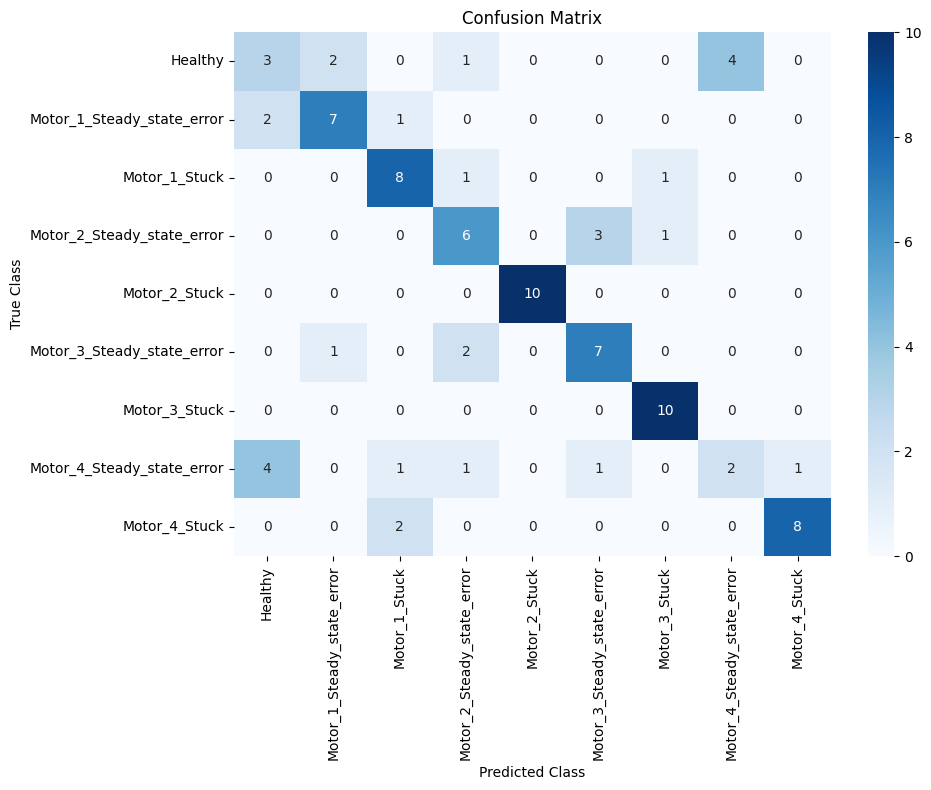

Accuracy: 0.6778
Weighted F1 Score: 0.6647


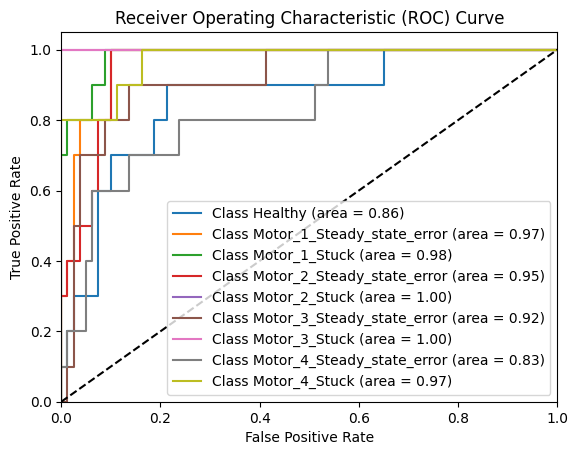


Performance Comparison:
Validation Set - Accuracy: 0.8278, F1 Score: 0.8275
Target Domain  - Accuracy: 0.6778, F1 Score: 0.6647


'# architecture diagram #\nfrom torchviz import make_dot\nx = torch.randn(1, max_len, input_size).to(device)\ny, _ = model(x)\ndot = make_dot(y, params=dict(model.named_parameters()))\ndot.render("cdan_model_architecture", format="png")\n'

In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
#import torchviz

import matplotlib.pyplot as plt
import seaborn as sns
import logging
np.random.seed(40)
torch.manual_seed(40)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("cdan_training.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

#####################################################################
###### Data Loading and Preprocessing ###############################
####################################################################
def load_and_preprocess_data(source_path, target_path=None):
    # Load source domain data
    data = pd.read_csv(source_path)
    data = data.drop(['matFilePath'], axis=1)  # Remove irrelevant columns

    ################ FeatureEng ###########################################################################
    data['Residual-x'] = data['DesiredTrajectory-x'] - data['RealizedTrajectory-x']
    data['Residual-y'] = data['DesiredTrajectory-y'] - data['RealizedTrajectory-y']
    data['Residual-z'] = data['DesiredTrajectory-z'] - data['RealizedTrajectory-z']
    
    feature_cols = [
        'Motor1Cmd', 'Motor2Cmd', 'Motor3Cmd', 'Motor4Cmd',
        'DesiredTrajectory-x', 'DesiredTrajectory-y', 'DesiredTrajectory-z',
        'RealizedTrajectory-x', 'RealizedTrajectory-y', 'RealizedTrajectory-z',
        'Residual-x', 'Residual-y', 'Residual-z'
    ]
    
    ##########################################################################################################
    
    
    # Extracting features and target label
    X = data[feature_cols]
    y = data['Target']
    timestamps = data['Timestamps'] #just for indexing
    
    # Normalization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # One-hot encode the target
    encoder = OneHotEncoder(sparse_output=False) #previous, sparse=
    y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))
    
    # Build sequences
    sequences = []
    labels = []
    current_sequence = []
    current_labels = []
    
    for i in range(len(X_scaled)):
        current_sequence.append(X_scaled[i])
        current_labels.append(y.iloc[i])
        if i < len(X_scaled) - 1 and timestamps.iloc[i + 1] == 0.0:
            sequences.append(current_sequence)
            labels.append(current_labels[-1])  # Use the last label of the sequence
            current_sequence = []
            current_labels = []
    
    # Add the last sequence (range from 0.0 to 9.99) if it exists
    if current_sequence:
        sequences.append(current_sequence)
        labels.append(current_labels[-1])
    
    # Determine the maximum sequence length
    sequence_length = max(len(seq) for seq in sequences)
    num_features = X.shape[1]
    
    # Pad sequences to have the same length (if seq < range(0.00 to 9.99))
    padded_sequences = []
    for seq in sequences:
        if len(seq) < sequence_length:
            padding = [[0] * num_features] * (sequence_length - len(seq))
            seq.extend(padding)
        padded_sequences.append(seq)
    
    X_padded = np.array(padded_sequences)
    y_array = np.array(labels)
    
    # One-hot encode labels
    y_encoded = encoder.transform(y_array.reshape(-1, 1))
    
    # Split into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_padded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    # Create PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)
    
    # Create TensorDatasets and DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Feature Engineering and Process target domain data
    if target_path:
        target_data = pd.read_csv(target_path)
        # feature eng: computing residual cols
        target_data['Residual-x'] = target_data['DesiredTrajectory-x'] - target_data['RealizedTrajectory-x']
        target_data['Residual-y'] = target_data['DesiredTrajectory-y'] - target_data['RealizedTrajectory-y']
        target_data['Residual-z'] = target_data['DesiredTrajectory-z'] - target_data['RealizedTrajectory-z']
        X_target = target_data[feature_cols]
        y_target = target_data['Target']
        timestamps_target = target_data['Timestamps']
        
        # Use the same scaler as source domain
        X_target_scaled = scaler.transform(X_target)
        
        # Build sequences for target domain
        target_sequences = []
        target_labels = []
        current_sequence = []
        current_labels = []
        
        for i in range(len(X_target_scaled)):
            current_sequence.append(X_target_scaled[i])
            current_labels.append(y_target.iloc[i])
            if i < len(X_target_scaled) - 1 and timestamps_target.iloc[i + 1] == 0.0:
                target_sequences.append(current_sequence)
                target_labels.append(current_labels[-1])
                current_sequence = []
                current_labels = []
        
        if current_sequence:
            target_sequences.append(current_sequence)
            target_labels.append(current_labels[-1])
        
        # Pad target sequences, just as before..
        padded_target_sequences = []
        for seq in target_sequences:
            if len(seq) < sequence_length:
                padding = [[0] * num_features] * (sequence_length - len(seq))
                seq.extend(padding)
            padded_target_sequences.append(seq)
        
        X_target_padded = np.array(padded_target_sequences)
        y_target_array = np.array(target_labels)
        
        # One-hot encode target labels using the same encoder...
        y_target_encoded = encoder.transform(y_target_array.reshape(-1, 1))
        
        # Create tensors for target domain...
        X_target_tensor = torch.FloatTensor(X_target_padded).to(device)
        y_target_tensor = torch.FloatTensor(y_target_encoded).to(device)
        
        # Create dataset and dataloader for target domain..
        target_dataset = TensorDataset(X_target_tensor, y_target_tensor)
        target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True)
        
        return {
            'train_loader': train_loader,
            'val_loader': val_loader,
            'target_loader': target_loader,
            'sequence_length': sequence_length,
            'num_features': num_features,
            'num_classes': y_encoded.shape[1],
            'scaler': scaler,
            'encoder': encoder,
            'X_train_tensor': X_train_tensor,
            'y_train_tensor': y_train_tensor,
            'X_val_tensor': X_val_tensor,
            'y_val_tensor': y_val_tensor,
            'X_target_tensor': X_target_tensor,
            'y_target_tensor': y_target_tensor
        }
    
    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'sequence_length': sequence_length,
        'num_features': num_features,
        'num_classes': y_encoded.shape[1],
        'scaler': scaler,
        'encoder': encoder,
        'X_train_tensor': X_train_tensor,
        'y_train_tensor': y_train_tensor,
        'X_val_tensor': X_val_tensor,
        'y_val_tensor': y_val_tensor
    }

#################################################
#### Feature Extractor - Transformer Encoder ####
#################################################
class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=256):
        super(LearnablePositionalEncoding, self).__init__()
        self.pos_embedding = nn.Embedding(max_len, d_model)
        self.max_len = max_len

    def forward(self, x):
        # x shape: [batch_size, seq_length, d_model]
        batch_size, seq_length, _ = x.size()
        positions = torch.arange(0, seq_length, device=x.device).unsqueeze(0).expand(batch_size, seq_length)
        return x + self.pos_embedding(positions)


class FeatureExtractor(nn.Module):
    def __init__(self, input_size, hidden_size, max_len, num_heads=8, num_layers=6, dropout=0.1):
        super(FeatureExtractor, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.Dropout(dropout)
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_size))
        self.pos_encoder = LearnablePositionalEncoding(hidden_size, max_len+1)

        # Transformer encoder layers with residual connections
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=hidden_size,
                nhead=num_heads,
                dim_feedforward=hidden_size*4,
                dropout=dropout,
                batch_first=True,
                activation='gelu'
            ) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(hidden_size)
        self.batch_norm = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = self.embedding(x)
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = self.pos_encoder(x)

        # Apply transformer encoder layers with residual connections: self-attention mechanisms to capture dependencies between different positions in the input sequenc
        for layer in self.encoder_layers:
            x = layer(x) + x  # Residual connection

        x = self.layer_norm(x)
        features = x.mean(dim=1)  # Global pooling over sequence
        features = self.batch_norm(features)  # normalization
        return features


########################################
#### Label Predictor ###################
########################################
class LabelPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout=0.2):
        super(LabelPredictor, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

########################################
# Domain Classifier ####################
########################################
class DomainClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(DomainClassifier, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout)
        )

        # Skip Connection
        self.shortcut = nn.Linear(input_size, hidden_size // 4)

        # Binary Output with Sigmoid Activation
        self.output = nn.Linear(hidden_size // 4, 1)  

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)

        # Skip Connection
        x_shortcut = self.shortcut(x)
        x_final = x3 + x_shortcut  

        return self.output(x_final)  # Binary Output
        
################################################
# Gradient Reversal Layer for Domain Adaptation
################################################
class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class GradientReversal(nn.Module):
    def __init__(self, alpha=1.0):
        super(GradientReversal, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        return GradientReversalLayer.apply(x, self.alpha)

#####################
# CDAN Implementation
#####################
class CDAN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, max_len, num_heads=8, num_layers=4, dropout=0.2):
        super(CDAN, self).__init__()
        self.feature_extractor = FeatureExtractor(input_size, hidden_size, max_len, num_heads, num_layers, dropout)
        self.label_predictor = LabelPredictor(hidden_size, hidden_size//2, num_classes, dropout)
        
        # For the multilinear mapping in CDAN
        feature_out_dim = hidden_size
        class_out_dim = num_classes
        
        # Random matrix for multilinear map approximation
        self.randomized = True
        if self.randomized:
            self.random_matrix = torch.nn.Parameter(
                torch.randn(feature_out_dim * class_out_dim, hidden_size), requires_grad=False)
        
        # Domain classifier dimensions adjusted for randomized or not
        domain_input_dim = hidden_size
        self.domain_classifier = nn.Sequential(
            GradientReversal(),
            nn.Linear(domain_input_dim, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size//2, hidden_size//4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size//4, 1)  # Removed sigmoid for BCEWithLogitsLoss
        )

    def forward(self, x, alpha=1.0):
        features = self.feature_extractor(x)
        class_output = self.label_predictor(features)
        class_probabilities = F.softmax(class_output, dim=1)
        
        # For domain adaptation
        if self.training:
            # Update gradient reversal layer alpha
            for layer in self.domain_classifier:
                if isinstance(layer, GradientReversal):
                    layer.alpha = alpha
            
            # Multilinear map (tensor product)
            if self.randomized:
                # Approximation with random projection
                softmax_output = class_probabilities
                op_out = torch.bmm(softmax_output.unsqueeze(2), features.unsqueeze(1))
                op_out = op_out.view(-1, softmax_output.size(1) * features.size(1))
                domain_input = torch.mm(op_out, self.random_matrix)
            else:
                # Direct tensor product
                softmax_output = class_probabilities
                domain_input = torch.bmm(softmax_output.unsqueeze(2), features.unsqueezalphae(1))
                domain_input = domain_input.view(-1, softmax_output.size(1) * features.size(1))
            
            domain_output = self.domain_classifier(domain_input)
            return class_output, domain_output
        
        return class_output, None

#####################
# Training Function
#####################
def train_cdan(model, source_loader, target_loader, criterion, optimizer, scheduler, num_epochs=30, early_stopping_patience=5):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_loss = float('inf')
    epochs_no_improve = 0

    scaler = GradScaler()  # For mixed precision training
    
    # Domain loss with logits (safe for autocast)
    domain_criterion = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        # Calculate adaptive factor for gradient reversal
        p = epoch / num_epochs
        #alpha = 2. / (1. + np.exp(-10 * p)) - 1
        alpha = 2. / (1. + np.exp(-5 * p)) - 1
        # Training phase
        model.train()
        running_loss = 0.0
        running_cls_loss = 0.0
        running_domain_loss = 0.0
        correct = 0
        total = 0
        
        source_iter = iter(source_loader)
        target_iter = iter(target_loader)
        num_batches = min(len(source_loader), len(target_loader))
        
        for _ in tqdm(range(num_batches), desc=f"Epoch {epoch+1} Training"):
            # Source data
            try:
                source_data, source_labels = next(source_iter)
            except StopIteration:
                source_iter = iter(source_loader)
                source_data, source_labels = next(source_iter)
            
            # Target data
            try:
                target_data, _ = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                target_data, _ = next(target_iter)
            
            source_data, source_labels = source_data.to(device), source_labels.to(device)
            target_data = target_data.to(device)
            source_domain_labels = torch.ones(source_data.size(0), 1).to(device)
            target_domain_labels = torch.zeros(target_data.size(0), 1).to(device)
            
            optimizer.zero_grad()
            
            with autocast():  # Mixed precision
                # Forward pass for source domain
                class_outputs, domain_outputs = model(source_data, alpha)
                
                # Convert one-hot encoded labels to class indices
                source_label_indices = torch.max(source_labels, 1)[1]
                
                # Calculate classification loss
                cls_loss = criterion(class_outputs, source_label_indices)
                
                # Forward pass for target domain
                _, target_domain_outputs = model(target_data, alpha)
                
                # Calculate domain classification loss using BCEWithLogitsLoss
                domain_loss = domain_criterion(domain_outputs, source_domain_labels) + \
                             domain_criterion(target_domain_outputs, target_domain_labels)
                
                # Total loss
                loss = cls_loss + domain_loss
            
            # Backward pass and optimize with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # Statistics
            running_loss += loss.item()
            running_cls_loss += cls_loss.item()
            running_domain_loss += domain_loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(class_outputs.data, 1)
            total += source_label_indices.size(0)
            correct += (predicted == source_label_indices).sum().item()
        
        train_loss = running_loss / num_batches
        train_cls_loss = running_cls_loss / num_batches
        train_domain_loss = running_domain_loss / num_batches
        train_acc = 100 * correct / total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, labels in tqdm(source_loader, desc=f"Epoch {epoch+1} Validation"):
                data, labels = data.to(device), labels.to(device)
                label_indices = torch.max(labels, 1)[1]
                
                outputs, _ = model(data)
                loss = criterion(outputs, label_indices)
                
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += label_indices.size(0)
                correct += (predicted == label_indices).sum().item()
        
        avg_val_loss = val_loss / len(source_loader)
        val_acc = 100 * correct / total
        
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        
        # Update learning rate scheduler
        scheduler.step(avg_val_loss)
        
        # Print statistics
        info_str = (f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} (Class: {train_cls_loss:.4f}, Domain: {train_domain_loss:.4f}), "
                    f"Train Acc: {train_acc:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        logger.info(info_str)
        print(info_str)
        
        # Early stopping check
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_cdan_model.pth')
            logger.info("Best model saved.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= early_stopping_patience:
            logger.info("Early stopping triggered.")
            break
    
    return model, history

#####################
# Evaluation
#####################
def evaluate_model(model, test_loader, encoder):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in tqdm(test_loader, desc="Evaluating"):
            data, labels = data.to(device), labels.to(device)
            outputs, _ = model(data)

            # Convert outputs to predicted class
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())

            # Convert one-hot encoded labels to class indices
            label_indices = torch.max(labels, 1)[1]
            all_labels.extend(label_indices.cpu().numpy())

            # Get probabilities for ROC AUC
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)

    # Compute metrics
    cm = confusion_matrix(all_labels, all_preds)
    class_names = encoder.categories_[0]

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    plt.close()

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"Weighted F1 Score: {f1:.4f}")

    # Calculate ROC AUC
    all_probs = np.array(all_probs)
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    plt.close()

    return acc, f1


#####################
# Plots
#####################
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Training and Validation Loss")
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title("Training and Validation Accuracy")
    
    plt.tight_layout()
    plt.show()
    plt.close()



data_info = load_and_preprocess_data(
    source_path='/kaggle/input/dataset/combined_data.csv',
    target_path='/kaggle/input/dataset/combined_testing_data.csv'
)


# Model hyperparams
input_size = data_info['num_features']
hidden_size = 256
num_classes = data_info['num_classes']
max_len = data_info['sequence_length']
num_heads = 32 # Make sure hidden_size is divisible by num_heads
num_layers = 10

# Initialize CDAN model
model = CDAN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_classes=num_classes,
    max_len=max_len,
    num_heads=num_heads,
    num_layers=num_layers
).to(device)


# Wrapping the model with DataParallel just if running multiple GPUs
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=4, factor=0.5, verbose=True
)

# Model training
model, history = train_cdan(
    model=model,
    source_loader=data_info['train_loader'],
    target_loader=data_info['target_loader'],
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=150,
    early_stopping_patience=15
)

# Plot learning curves
plot_learning_curves(history)

# Loading best model for eval
model.load_state_dict(torch.load('best_cdan_model.pth'))

# Evaluate on validation set (real test data)
print("\nEvaluating on validation set:")
val_acc, val_f1 = evaluate_model(
    model=model,
    test_loader=data_info['val_loader'],
    encoder=data_info['encoder']
)

# on target domain
print("\nEvaluating on target domain:")
target_acc, target_f1 = evaluate_model(
    model=model,
    test_loader=data_info['target_loader'],
    encoder=data_info['encoder']
)

# Comparing results
print("\nPerformance Comparison:")
print(f"Validation Set - Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}")
print(f"Target Domain  - Accuracy: {target_acc:.4f}, F1 Score: {target_f1:.4f}")


"""# architecture diagram #
from torchviz import make_dot
x = torch.randn(1, max_len, input_size).to(device)
y, _ = model(x)
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render("cdan_model_architecture", format="png")
"""

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-24-aa92952cd845>:423: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training
Epoch 1 Training:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-24-aa92952cd845>:467: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
Epoch 1 Validation: 100%|██████████| 90/90 [00:47<00:00,  1.88it/s]


Epoch 1: Train Loss: 3.8964 (Class: 2.3318, Domain: 1.5647), Train Acc: 14.58%, Val Loss: 2.1978, Val Acc: 16.04%


Epoch 2 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.93it/s]


Epoch 2: Train Loss: 3.9180 (Class: 2.2534, Domain: 1.6646), Train Acc: 11.46%, Val Loss: 2.2246, Val Acc: 16.63%


Epoch 3 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.92it/s]


Epoch 3: Train Loss: 3.8859 (Class: 2.2765, Domain: 1.6094), Train Acc: 14.58%, Val Loss: 2.1957, Val Acc: 18.44%


Epoch 4 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 4: Train Loss: 3.5736 (Class: 2.0537, Domain: 1.5199), Train Acc: 19.79%, Val Loss: 2.0285, Val Acc: 23.54%


Epoch 5 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.93it/s]


Epoch 5: Train Loss: 3.6074 (Class: 1.8868, Domain: 1.7206), Train Acc: 20.83%, Val Loss: 1.8847, Val Acc: 27.85%


Epoch 6 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 6: Train Loss: 3.5961 (Class: 1.8561, Domain: 1.7400), Train Acc: 25.00%, Val Loss: 1.8548, Val Acc: 26.42%


Epoch 7 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 7: Train Loss: 3.2989 (Class: 1.7801, Domain: 1.5188), Train Acc: 26.04%, Val Loss: 1.7056, Val Acc: 31.01%


Epoch 8 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 8: Train Loss: 3.4465 (Class: 1.7479, Domain: 1.6986), Train Acc: 32.29%, Val Loss: 1.9381, Val Acc: 26.53%


Epoch 9 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 9: Train Loss: 3.3071 (Class: 1.8608, Domain: 1.4463), Train Acc: 25.00%, Val Loss: 1.9276, Val Acc: 23.58%


Epoch 10 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 10: Train Loss: 3.2561 (Class: 1.6944, Domain: 1.5617), Train Acc: 31.25%, Val Loss: 1.6533, Val Acc: 34.34%


Epoch 11 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 11: Train Loss: 3.1966 (Class: 1.6771, Domain: 1.5195), Train Acc: 38.54%, Val Loss: 1.5813, Val Acc: 34.83%


Epoch 12 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.93it/s]


Epoch 12: Train Loss: 3.0222 (Class: 1.4710, Domain: 1.5512), Train Acc: 41.67%, Val Loss: 2.4421, Val Acc: 17.74%


Epoch 13 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 13: Train Loss: 3.1886 (Class: 1.6513, Domain: 1.5373), Train Acc: 34.38%, Val Loss: 2.3782, Val Acc: 19.69%


Epoch 14 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 14: Train Loss: 3.3442 (Class: 1.5349, Domain: 1.8093), Train Acc: 34.38%, Val Loss: 1.6290, Val Acc: 31.77%


Epoch 15 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 15: Train Loss: 2.9667 (Class: 1.2414, Domain: 1.7254), Train Acc: 59.38%, Val Loss: 1.4585, Val Acc: 38.75%


Epoch 16 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 16: Train Loss: 3.0314 (Class: 1.4775, Domain: 1.5539), Train Acc: 42.71%, Val Loss: 1.3312, Val Acc: 45.31%


Epoch 17 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 17: Train Loss: 3.0506 (Class: 1.4801, Domain: 1.5705), Train Acc: 44.79%, Val Loss: 1.5289, Val Acc: 41.77%


Epoch 18 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 18: Train Loss: 2.9417 (Class: 1.2925, Domain: 1.6492), Train Acc: 46.88%, Val Loss: 1.2562, Val Acc: 46.94%


Epoch 19 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 19: Train Loss: 2.7640 (Class: 1.1557, Domain: 1.6083), Train Acc: 50.00%, Val Loss: 1.1343, Val Acc: 52.95%


Epoch 20 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 20: Train Loss: 2.6682 (Class: 0.9785, Domain: 1.6897), Train Acc: 60.42%, Val Loss: 1.3937, Val Acc: 47.57%


Epoch 21 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 21: Train Loss: 2.6254 (Class: 1.1361, Domain: 1.4893), Train Acc: 53.12%, Val Loss: 1.3523, Val Acc: 44.79%


Epoch 22 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.93it/s]


Epoch 22: Train Loss: 2.6236 (Class: 1.0950, Domain: 1.5286), Train Acc: 61.46%, Val Loss: 1.3415, Val Acc: 49.10%


Epoch 23 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 23: Train Loss: 2.9615 (Class: 1.3938, Domain: 1.5677), Train Acc: 46.88%, Val Loss: 1.4763, Val Acc: 44.27%


Epoch 24 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 24: Train Loss: 2.6465 (Class: 1.1448, Domain: 1.5018), Train Acc: 60.42%, Val Loss: 1.7462, Val Acc: 43.82%


Epoch 25 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 25: Train Loss: 2.7828 (Class: 1.1149, Domain: 1.6679), Train Acc: 59.38%, Val Loss: 1.5632, Val Acc: 43.37%


Epoch 26 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 26: Train Loss: 2.6763 (Class: 1.1202, Domain: 1.5561), Train Acc: 52.08%, Val Loss: 1.2010, Val Acc: 51.94%


Epoch 27 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.95it/s]


Epoch 27: Train Loss: 2.6337 (Class: 1.0655, Domain: 1.5682), Train Acc: 60.42%, Val Loss: 1.1613, Val Acc: 53.78%


Epoch 28 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 28: Train Loss: 2.7398 (Class: 1.2223, Domain: 1.5175), Train Acc: 48.96%, Val Loss: 1.1826, Val Acc: 53.26%


Epoch 29 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 29: Train Loss: 2.6586 (Class: 1.1081, Domain: 1.5504), Train Acc: 58.33%, Val Loss: 1.2083, Val Acc: 53.40%


Epoch 30 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 30: Train Loss: 2.6587 (Class: 1.0981, Domain: 1.5606), Train Acc: 57.29%, Val Loss: 1.1285, Val Acc: 55.07%


Epoch 31 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 31: Train Loss: 2.5597 (Class: 0.9978, Domain: 1.5619), Train Acc: 67.71%, Val Loss: 1.0756, Val Acc: 56.32%


Epoch 32 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 32: Train Loss: 2.6289 (Class: 1.0826, Domain: 1.5463), Train Acc: 60.42%, Val Loss: 1.0812, Val Acc: 54.93%


Epoch 33 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 33: Train Loss: 2.4823 (Class: 0.9689, Domain: 1.5134), Train Acc: 58.33%, Val Loss: 1.0287, Val Acc: 55.69%


Epoch 34 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.95it/s]


Epoch 34: Train Loss: 2.5672 (Class: 1.0012, Domain: 1.5659), Train Acc: 55.21%, Val Loss: 0.9155, Val Acc: 60.90%


Epoch 35 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 35: Train Loss: 2.4938 (Class: 1.0314, Domain: 1.4624), Train Acc: 54.17%, Val Loss: 0.8722, Val Acc: 64.72%


Epoch 36 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 36: Train Loss: 2.4153 (Class: 0.8911, Domain: 1.5242), Train Acc: 61.46%, Val Loss: 0.8683, Val Acc: 62.78%


Epoch 37 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 37: Train Loss: 2.4776 (Class: 0.8992, Domain: 1.5784), Train Acc: 65.62%, Val Loss: 0.9008, Val Acc: 60.17%


Epoch 38 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 38: Train Loss: 2.4065 (Class: 0.8811, Domain: 1.5254), Train Acc: 63.54%, Val Loss: 1.1037, Val Acc: 55.80%


Epoch 39 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 39: Train Loss: 2.3315 (Class: 0.8818, Domain: 1.4497), Train Acc: 62.50%, Val Loss: 1.2093, Val Acc: 53.65%


Epoch 40 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 40: Train Loss: 2.4221 (Class: 0.9342, Domain: 1.4879), Train Acc: 62.50%, Val Loss: 0.9918, Val Acc: 60.62%


Epoch 41 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 41: Train Loss: 2.3286 (Class: 0.8736, Domain: 1.4550), Train Acc: 59.38%, Val Loss: 0.8355, Val Acc: 65.52%


Epoch 42 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.95it/s]


Epoch 42: Train Loss: 2.4606 (Class: 0.9633, Domain: 1.4973), Train Acc: 65.62%, Val Loss: 0.8377, Val Acc: 64.10%


Epoch 43 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 43: Train Loss: 2.3843 (Class: 0.9535, Domain: 1.4309), Train Acc: 61.46%, Val Loss: 0.8769, Val Acc: 63.19%


Epoch 44 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 44: Train Loss: 2.4995 (Class: 0.9760, Domain: 1.5234), Train Acc: 59.38%, Val Loss: 1.1740, Val Acc: 54.72%


Epoch 45 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 45: Train Loss: 2.4501 (Class: 0.9325, Domain: 1.5176), Train Acc: 63.54%, Val Loss: 0.9165, Val Acc: 60.24%


Epoch 46 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 46: Train Loss: 2.2252 (Class: 0.7875, Domain: 1.4377), Train Acc: 64.58%, Val Loss: 0.8072, Val Acc: 68.09%


Epoch 47 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 47: Train Loss: 2.3226 (Class: 0.8416, Domain: 1.4809), Train Acc: 66.67%, Val Loss: 0.8151, Val Acc: 67.26%


Epoch 48 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 48: Train Loss: 2.4155 (Class: 0.9311, Domain: 1.4844), Train Acc: 66.67%, Val Loss: 0.7627, Val Acc: 69.44%


Epoch 49 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.95it/s]


Epoch 49: Train Loss: 2.2548 (Class: 0.7907, Domain: 1.4640), Train Acc: 67.71%, Val Loss: 0.7328, Val Acc: 70.62%


Epoch 50 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 50: Train Loss: 2.3622 (Class: 0.8763, Domain: 1.4859), Train Acc: 65.62%, Val Loss: 0.8762, Val Acc: 63.09%


Epoch 51 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 51: Train Loss: 2.2733 (Class: 0.8701, Domain: 1.4032), Train Acc: 66.67%, Val Loss: 1.0936, Val Acc: 59.20%


Epoch 52 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 52: Train Loss: 2.3455 (Class: 0.8695, Domain: 1.4760), Train Acc: 65.62%, Val Loss: 1.1475, Val Acc: 61.22%


Epoch 53 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 53: Train Loss: 2.4750 (Class: 0.9773, Domain: 1.4978), Train Acc: 59.38%, Val Loss: 0.9158, Val Acc: 66.67%


Epoch 54 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 54: Train Loss: 2.2537 (Class: 0.8293, Domain: 1.4244), Train Acc: 63.54%, Val Loss: 0.7620, Val Acc: 69.31%


Epoch 55 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 55: Train Loss: 2.4858 (Class: 1.0204, Domain: 1.4654), Train Acc: 65.62%, Val Loss: 0.7027, Val Acc: 71.08%


Epoch 56 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 56: Train Loss: 2.1275 (Class: 0.7344, Domain: 1.3931), Train Acc: 75.00%, Val Loss: 0.7351, Val Acc: 69.76%


Epoch 57 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 57: Train Loss: 2.2034 (Class: 0.7591, Domain: 1.4444), Train Acc: 66.67%, Val Loss: 0.8427, Val Acc: 67.08%


Epoch 58 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 58: Train Loss: 2.0898 (Class: 0.6565, Domain: 1.4333), Train Acc: 76.04%, Val Loss: 0.8533, Val Acc: 66.70%


Epoch 59 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 59: Train Loss: 2.2219 (Class: 0.7660, Domain: 1.4559), Train Acc: 65.62%, Val Loss: 0.8197, Val Acc: 67.15%


Epoch 60 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 60: Train Loss: 2.1215 (Class: 0.6415, Domain: 1.4799), Train Acc: 73.96%, Val Loss: 0.8518, Val Acc: 66.08%


Epoch 61 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 61: Train Loss: 2.2445 (Class: 0.7490, Domain: 1.4955), Train Acc: 66.67%, Val Loss: 0.8405, Val Acc: 66.25%


Epoch 62 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 62: Train Loss: 2.1612 (Class: 0.7299, Domain: 1.4313), Train Acc: 69.79%, Val Loss: 0.8485, Val Acc: 65.35%


Epoch 63 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.93it/s]


Epoch 63: Train Loss: 2.1989 (Class: 0.7980, Domain: 1.4009), Train Acc: 66.67%, Val Loss: 0.8306, Val Acc: 65.28%


Epoch 64 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 64: Train Loss: 2.0345 (Class: 0.6500, Domain: 1.3845), Train Acc: 77.08%, Val Loss: 0.7824, Val Acc: 66.91%


Epoch 65 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 65: Train Loss: 2.0349 (Class: 0.5852, Domain: 1.4497), Train Acc: 81.25%, Val Loss: 0.7342, Val Acc: 68.75%


Epoch 66 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 66: Train Loss: 2.1176 (Class: 0.6720, Domain: 1.4456), Train Acc: 70.83%, Val Loss: 0.7021, Val Acc: 70.31%


Epoch 67 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 67: Train Loss: 2.0274 (Class: 0.6293, Domain: 1.3981), Train Acc: 78.12%, Val Loss: 0.6839, Val Acc: 71.11%


Epoch 68 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.95it/s]


Epoch 68: Train Loss: 2.0401 (Class: 0.5827, Domain: 1.4575), Train Acc: 79.17%, Val Loss: 0.6510, Val Acc: 72.71%


Epoch 69 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 69: Train Loss: 2.1527 (Class: 0.7029, Domain: 1.4498), Train Acc: 73.96%, Val Loss: 0.6340, Val Acc: 73.96%


Epoch 70 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.93it/s]


Epoch 70: Train Loss: 2.0594 (Class: 0.6468, Domain: 1.4126), Train Acc: 71.88%, Val Loss: 0.6382, Val Acc: 73.78%


Epoch 71 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 71: Train Loss: 2.0403 (Class: 0.5984, Domain: 1.4419), Train Acc: 75.00%, Val Loss: 0.6352, Val Acc: 73.99%


Epoch 72 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 72: Train Loss: 2.1113 (Class: 0.6682, Domain: 1.4431), Train Acc: 71.88%, Val Loss: 0.6571, Val Acc: 72.85%


Epoch 73 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 73: Train Loss: 2.1298 (Class: 0.6967, Domain: 1.4331), Train Acc: 68.75%, Val Loss: 0.6420, Val Acc: 73.47%


Epoch 74 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 74: Train Loss: 2.0820 (Class: 0.6000, Domain: 1.4820), Train Acc: 78.12%, Val Loss: 0.6706, Val Acc: 71.94%


Epoch 75 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 75: Train Loss: 2.1477 (Class: 0.6899, Domain: 1.4577), Train Acc: 72.92%, Val Loss: 0.6628, Val Acc: 71.94%


Epoch 76 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 76: Train Loss: 2.1678 (Class: 0.6728, Domain: 1.4949), Train Acc: 75.00%, Val Loss: 0.6512, Val Acc: 72.50%


Epoch 77 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 77: Train Loss: 2.1555 (Class: 0.7375, Domain: 1.4180), Train Acc: 72.92%, Val Loss: 0.6351, Val Acc: 73.47%


Epoch 78 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 78: Train Loss: 2.1587 (Class: 0.6909, Domain: 1.4678), Train Acc: 73.96%, Val Loss: 0.6354, Val Acc: 73.30%


Epoch 79 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 79: Train Loss: 2.0860 (Class: 0.6012, Domain: 1.4847), Train Acc: 70.83%, Val Loss: 0.6412, Val Acc: 73.16%


Epoch 80 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.93it/s]


Epoch 80: Train Loss: 2.2047 (Class: 0.7255, Domain: 1.4791), Train Acc: 68.75%, Val Loss: 0.6427, Val Acc: 73.26%


Epoch 81 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 81: Train Loss: 1.9556 (Class: 0.4827, Domain: 1.4729), Train Acc: 85.42%, Val Loss: 0.6268, Val Acc: 73.75%


Epoch 82 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 82: Train Loss: 2.1890 (Class: 0.6958, Domain: 1.4933), Train Acc: 77.08%, Val Loss: 0.6258, Val Acc: 73.72%


Epoch 83 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 83: Train Loss: 2.1631 (Class: 0.6962, Domain: 1.4668), Train Acc: 67.71%, Val Loss: 0.6346, Val Acc: 73.68%


Epoch 84 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 84: Train Loss: 2.0861 (Class: 0.6405, Domain: 1.4457), Train Acc: 79.17%, Val Loss: 0.6334, Val Acc: 73.40%


Epoch 85 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 85: Train Loss: 2.1592 (Class: 0.6782, Domain: 1.4810), Train Acc: 71.88%, Val Loss: 0.6298, Val Acc: 73.58%


Epoch 86 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 86: Train Loss: 2.0536 (Class: 0.5870, Domain: 1.4666), Train Acc: 78.12%, Val Loss: 0.6189, Val Acc: 73.89%


Epoch 87 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.93it/s]


Epoch 87: Train Loss: 2.1141 (Class: 0.6548, Domain: 1.4593), Train Acc: 71.88%, Val Loss: 0.6242, Val Acc: 73.68%


Epoch 88 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 88: Train Loss: 2.0975 (Class: 0.6590, Domain: 1.4385), Train Acc: 77.08%, Val Loss: 0.6262, Val Acc: 73.68%


Epoch 89 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 89: Train Loss: 2.1279 (Class: 0.6980, Domain: 1.4299), Train Acc: 68.75%, Val Loss: 0.6401, Val Acc: 73.02%


Epoch 90 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 90: Train Loss: 2.0593 (Class: 0.6136, Domain: 1.4458), Train Acc: 73.96%, Val Loss: 0.6675, Val Acc: 71.84%


Epoch 91 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 91: Train Loss: 2.1831 (Class: 0.7117, Domain: 1.4714), Train Acc: 70.83%, Val Loss: 0.6846, Val Acc: 71.15%


Epoch 92 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 92: Train Loss: 2.1422 (Class: 0.6713, Domain: 1.4709), Train Acc: 72.92%, Val Loss: 0.6577, Val Acc: 72.50%


Epoch 93 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 93: Train Loss: 2.0003 (Class: 0.5601, Domain: 1.4402), Train Acc: 78.12%, Val Loss: 0.6738, Val Acc: 71.67%


Epoch 94 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.93it/s]


Epoch 94: Train Loss: 1.9934 (Class: 0.5540, Domain: 1.4394), Train Acc: 78.12%, Val Loss: 0.6729, Val Acc: 71.56%


Epoch 95 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 95: Train Loss: 2.1822 (Class: 0.7180, Domain: 1.4642), Train Acc: 69.79%, Val Loss: 0.6699, Val Acc: 71.74%


Epoch 96 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 96: Train Loss: 2.0733 (Class: 0.6541, Domain: 1.4192), Train Acc: 75.00%, Val Loss: 0.6715, Val Acc: 71.84%


Epoch 97 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 97: Train Loss: 2.1573 (Class: 0.7036, Domain: 1.4537), Train Acc: 72.92%, Val Loss: 0.6573, Val Acc: 72.33%


Epoch 98 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 98: Train Loss: 1.9809 (Class: 0.5547, Domain: 1.4262), Train Acc: 80.21%, Val Loss: 0.6517, Val Acc: 72.64%


Epoch 99 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 99: Train Loss: 2.1764 (Class: 0.6884, Domain: 1.4880), Train Acc: 71.88%, Val Loss: 0.6559, Val Acc: 72.60%


Epoch 100 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 100: Train Loss: 1.9417 (Class: 0.5112, Domain: 1.4305), Train Acc: 79.17%, Val Loss: 0.6469, Val Acc: 72.67%


Epoch 101 Validation: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Epoch 101: Train Loss: 2.0919 (Class: 0.6458, Domain: 1.4461), Train Acc: 76.04%, Val Loss: 0.6511, Val Acc: 72.67%


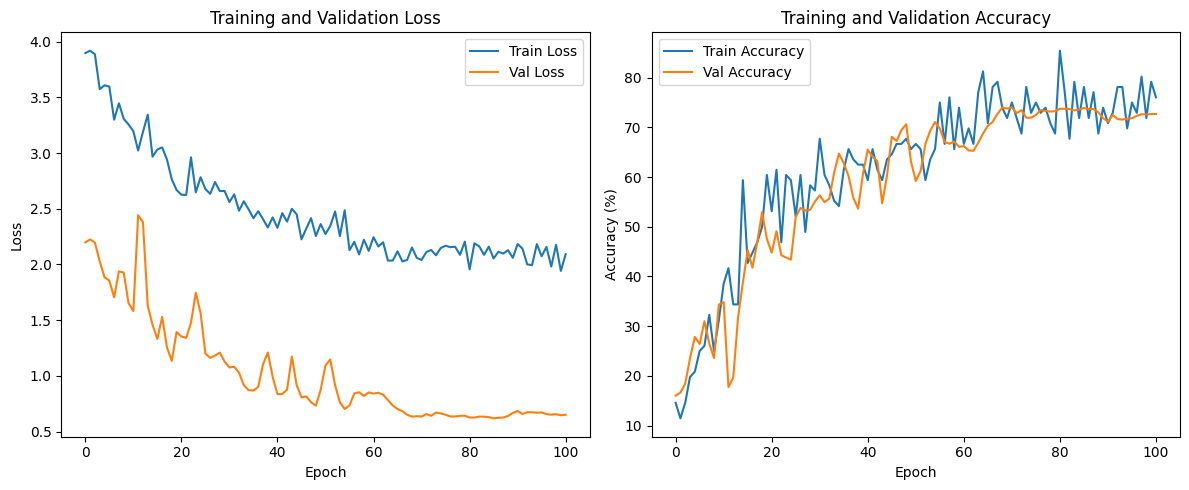

<ipython-input-24-aa92952cd845>:722: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cdan_model.pth'))



Evaluating on validation set:


Evaluating: 100%|██████████| 23/23 [00:11<00:00,  1.98it/s]


Classification Report:
                            precision    recall  f1-score   support

                   Healthy       0.44      0.91      0.60        80
Motor_1_Steady_state_error       0.57      0.55      0.56        80
             Motor_1_Stuck       0.97      0.97      0.97        80
Motor_2_Steady_state_error       0.84      0.68      0.75        80
             Motor_2_Stuck       0.99      0.93      0.95        80
Motor_3_Steady_state_error       0.75      0.53      0.62        80
             Motor_3_Stuck       0.94      0.93      0.93        80
Motor_4_Steady_state_error       0.38      0.16      0.23        80
             Motor_4_Stuck       0.74      0.84      0.79        80

                  accuracy                           0.72       720
                 macro avg       0.74      0.72      0.71       720
              weighted avg       0.74      0.72      0.71       720



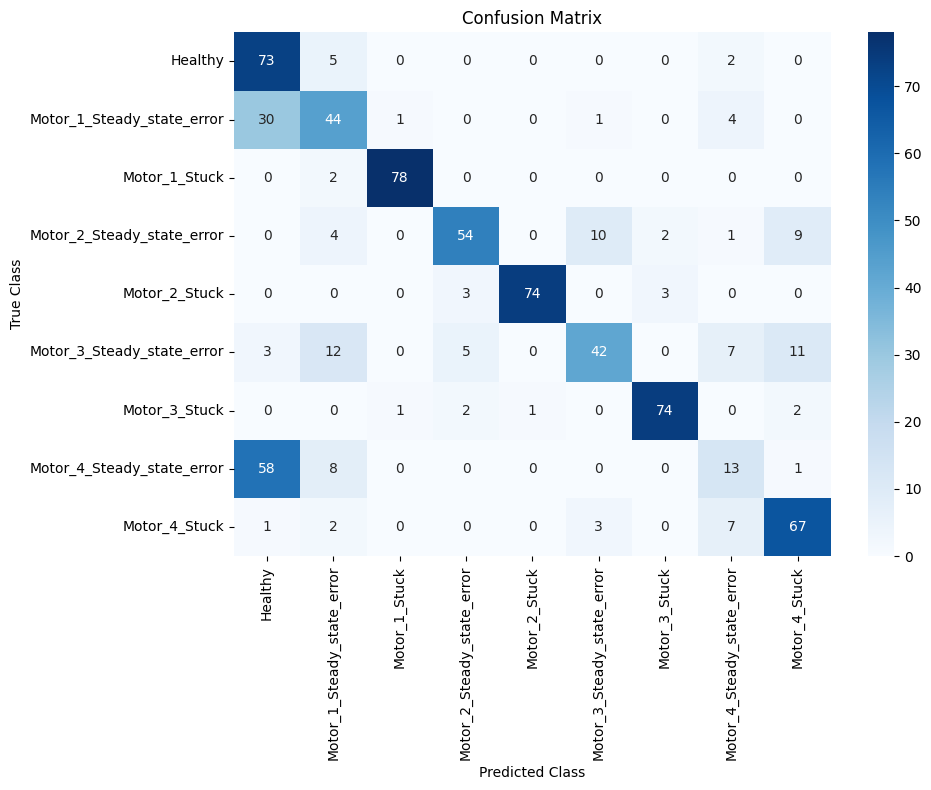

Accuracy: 0.7208
Weighted F1 Score: 0.7112


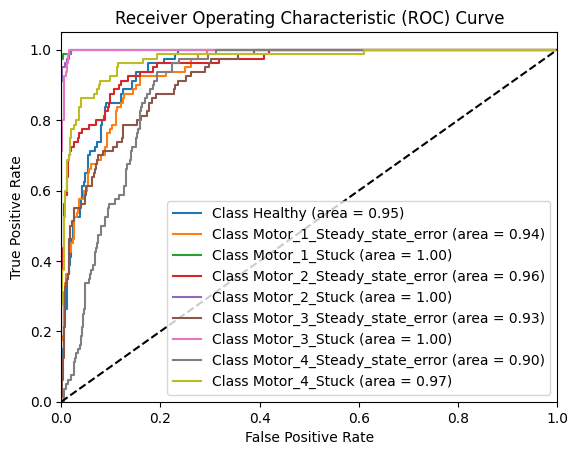


Evaluating on target domain:


Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


Classification Report:
                            precision    recall  f1-score   support

                   Healthy       0.27      0.30      0.29        10
Motor_1_Steady_state_error       0.40      0.60      0.48        10
             Motor_1_Stuck       0.69      0.90      0.78        10
Motor_2_Steady_state_error       0.58      0.70      0.64        10
             Motor_2_Stuck       1.00      0.90      0.95        10
Motor_3_Steady_state_error       0.40      0.20      0.27        10
             Motor_3_Stuck       0.83      1.00      0.91        10
Motor_4_Steady_state_error       0.67      0.20      0.31        10
             Motor_4_Stuck       0.70      0.70      0.70        10

                  accuracy                           0.61        90
                 macro avg       0.62      0.61      0.59        90
              weighted avg       0.62      0.61      0.59        90



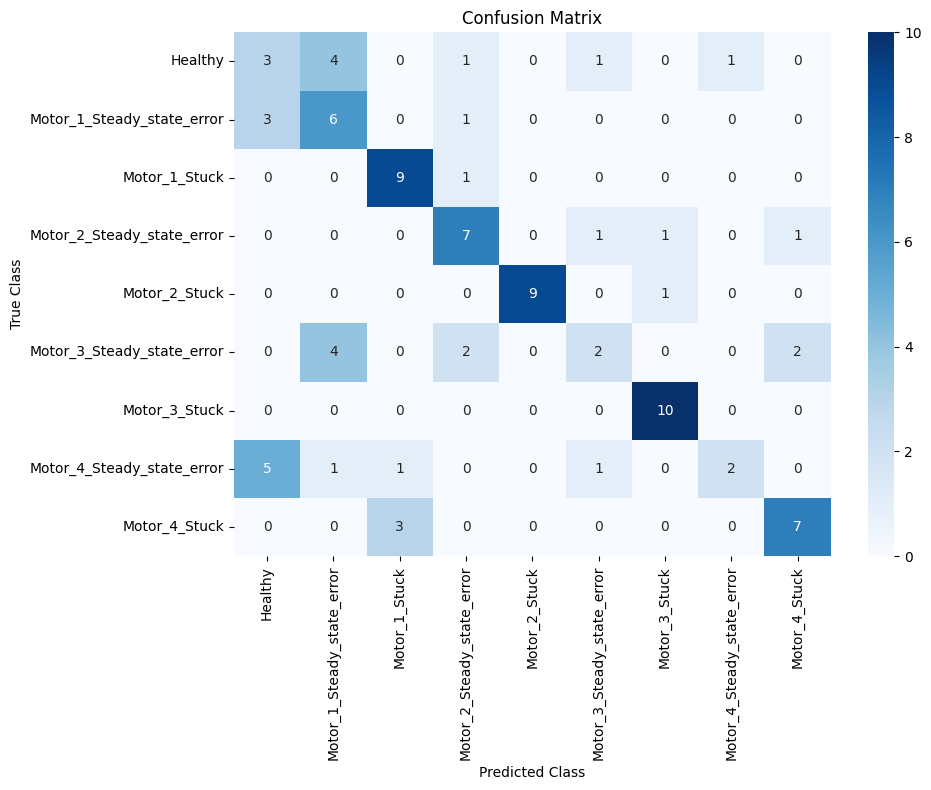

Accuracy: 0.6111
Weighted F1 Score: 0.5906


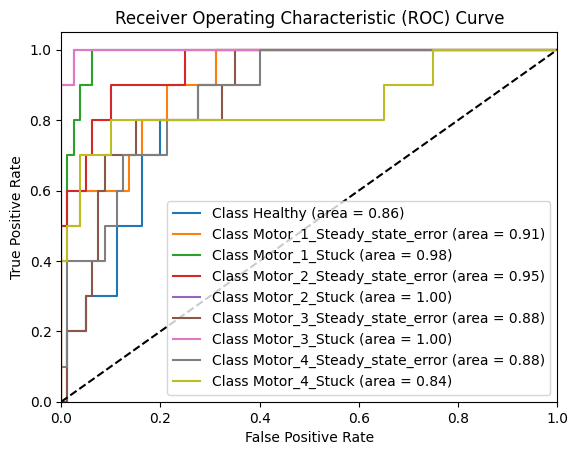


Performance Comparison:
Validation Set - Accuracy: 0.7208, F1 Score: 0.7112
Target Domain  - Accuracy: 0.6111, F1 Score: 0.5906


'# architecture diagram #\nfrom torchviz import make_dot\nx = torch.randn(1, max_len, input_size).to(device)\ny, _ = model(x)\ndot = make_dot(y, params=dict(model.named_parameters()))\ndot.render("cdan_model_architecture", format="png")'

In [24]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
#import torchviz

import matplotlib.pyplot as plt
import seaborn as sns
import logging
np.random.seed(40)
torch.manual_seed(40)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("cdan_training.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

#####################################################################
###### Data Loading and Preprocessing ###############################
####################################################################
def load_and_preprocess_data(source_path, target_path=None):
    # Load source domain data
    data = pd.read_csv(source_path)
    data = data.drop(['matFilePath'], axis=1)  # Remove irrelevant columns

    ################ FeatureEng ###########################################################################
    data['Residual-x'] = data['DesiredTrajectory-x'] - data['RealizedTrajectory-x']
    data['Residual-y'] = data['DesiredTrajectory-y'] - data['RealizedTrajectory-y']
    data['Residual-z'] = data['DesiredTrajectory-z'] - data['RealizedTrajectory-z']
    
    feature_cols = [
        'Motor1Cmd', 'Motor2Cmd', 'Motor3Cmd', 'Motor4Cmd',
        'DesiredTrajectory-x', 'DesiredTrajectory-y', 'DesiredTrajectory-z',
        'RealizedTrajectory-x', 'RealizedTrajectory-y', 'RealizedTrajectory-z',
        'Residual-x', 'Residual-y', 'Residual-z'
    ]
    
    ##########################################################################################################
    
    
    # Extracting features and target label
    X = data[feature_cols]
    y = data['Target']
    timestamps = data['Timestamps'] #just for indexing
    
    # Normalization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # One-hot encode the target
    encoder = OneHotEncoder(sparse_output=False) #previous, sparse=
    y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))
    
    # Build sequences
    sequences = []
    labels = []
    current_sequence = []
    current_labels = []
    
    for i in range(len(X_scaled)):
        current_sequence.append(X_scaled[i])
        current_labels.append(y.iloc[i])
        if i < len(X_scaled) - 1 and timestamps.iloc[i + 1] == 0.0:
            sequences.append(current_sequence)
            labels.append(current_labels[-1])  # Use the last label of the sequence
            current_sequence = []
            current_labels = []
    
    # Add the last sequence (range from 0.0 to 9.99) if it exists
    if current_sequence:
        sequences.append(current_sequence)
        labels.append(current_labels[-1])
    
    # Determine the maximum sequence length
    sequence_length = max(len(seq) for seq in sequences)
    num_features = X.shape[1]
    
    # Pad sequences to have the same length (if seq < range(0.00 to 9.99))
    padded_sequences = []
    for seq in sequences:
        if len(seq) < sequence_length:
            padding = [[0] * num_features] * (sequence_length - len(seq))
            seq.extend(padding)
        padded_sequences.append(seq)
    
    X_padded = np.array(padded_sequences)
    y_array = np.array(labels)
    
    # One-hot encode labels
    y_encoded = encoder.transform(y_array.reshape(-1, 1))
    
    # Split into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_padded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    # Create PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)
    
    # Create TensorDatasets and DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Feature Engineering and Process target domain data
    if target_path:
        target_data = pd.read_csv(target_path)
        # feature eng: computing residual cols
        target_data['Residual-x'] = target_data['DesiredTrajectory-x'] - target_data['RealizedTrajectory-x']
        target_data['Residual-y'] = target_data['DesiredTrajectory-y'] - target_data['RealizedTrajectory-y']
        target_data['Residual-z'] = target_data['DesiredTrajectory-z'] - target_data['RealizedTrajectory-z']
        X_target = target_data[feature_cols]
        y_target = target_data['Target']
        timestamps_target = target_data['Timestamps']
        
        # Use the same scaler as source domain
        X_target_scaled = scaler.transform(X_target)
        
        # Build sequences for target domain
        target_sequences = []
        target_labels = []
        current_sequence = []
        current_labels = []
        
        for i in range(len(X_target_scaled)):
            current_sequence.append(X_target_scaled[i])
            current_labels.append(y_target.iloc[i])
            if i < len(X_target_scaled) - 1 and timestamps_target.iloc[i + 1] == 0.0:
                target_sequences.append(current_sequence)
                target_labels.append(current_labels[-1])
                current_sequence = []
                current_labels = []
        
        if current_sequence:
            target_sequences.append(current_sequence)
            target_labels.append(current_labels[-1])
        
        # Pad target sequences, just as before..
        padded_target_sequences = []
        for seq in target_sequences:
            if len(seq) < sequence_length:
                padding = [[0] * num_features] * (sequence_length - len(seq))
                seq.extend(padding)
            padded_target_sequences.append(seq)
        
        X_target_padded = np.array(padded_target_sequences)
        y_target_array = np.array(target_labels)
        
        # One-hot encode target labels using the same encoder...
        y_target_encoded = encoder.transform(y_target_array.reshape(-1, 1))
        
        # Create tensors for target domain...
        X_target_tensor = torch.FloatTensor(X_target_padded).to(device)
        y_target_tensor = torch.FloatTensor(y_target_encoded).to(device)
        
        # Create dataset and dataloader for target domain..
        target_dataset = TensorDataset(X_target_tensor, y_target_tensor)
        target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True)
        
        return {
            'train_loader': train_loader,
            'val_loader': val_loader,
            'target_loader': target_loader,
            'sequence_length': sequence_length,
            'num_features': num_features,
            'num_classes': y_encoded.shape[1],
            'scaler': scaler,
            'encoder': encoder,
            'X_train_tensor': X_train_tensor,
            'y_train_tensor': y_train_tensor,
            'X_val_tensor': X_val_tensor,
            'y_val_tensor': y_val_tensor,
            'X_target_tensor': X_target_tensor,
            'y_target_tensor': y_target_tensor
        }
    
    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'sequence_length': sequence_length,
        'num_features': num_features,
        'num_classes': y_encoded.shape[1],
        'scaler': scaler,
        'encoder': encoder,
        'X_train_tensor': X_train_tensor,
        'y_train_tensor': y_train_tensor,
        'X_val_tensor': X_val_tensor,
        'y_val_tensor': y_val_tensor
    }

#################################################
#### Feature Extractor - Transformer Encoder ####
#################################################
class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=256):
        super(LearnablePositionalEncoding, self).__init__()
        self.pos_embedding = nn.Embedding(max_len, d_model)
        self.max_len = max_len

    def forward(self, x):
        # x shape: [batch_size, seq_length, d_model]
        batch_size, seq_length, _ = x.size()
        positions = torch.arange(0, seq_length, device=x.device).unsqueeze(0).expand(batch_size, seq_length)
        return x + self.pos_embedding(positions)


class FeatureExtractor(nn.Module):
    def __init__(self, input_size, hidden_size, max_len, num_heads=8, num_layers=6, dropout=0.1):
        super(FeatureExtractor, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.Dropout(dropout)
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_size))
        self.pos_encoder = LearnablePositionalEncoding(hidden_size, max_len+1)

        # Transformer encoder layers with residual connections
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=hidden_size,
                nhead=num_heads,
                dim_feedforward=hidden_size*4,
                dropout=dropout,
                batch_first=True,
                activation='gelu'
            ) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(hidden_size)
        self.batch_norm = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = self.embedding(x)
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = self.pos_encoder(x)

        # Apply transformer encoder layers with residual connections: self-attention mechanisms to capture dependencies between different positions in the input sequenc
        for layer in self.encoder_layers:
            x = layer(x) + x  # Residual connection

        x = self.layer_norm(x)
        features = x.mean(dim=1)  # Global pooling over sequence
        features = self.batch_norm(features)  # normalization
        return features


########################################
#### Label Predictor ###################
########################################
class LabelPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout=0.2):
        super(LabelPredictor, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

########################################
# Domain Classifier ####################
########################################
class DomainClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(DomainClassifier, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout)
        )

        # Skip Connection
        self.shortcut = nn.Linear(input_size, hidden_size // 4)

        # Binary Output with Sigmoid Activation
        self.output = nn.Linear(hidden_size // 4, 1)  

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)

        # Skip Connection
        x_shortcut = self.shortcut(x)
        x_final = x3 + x_shortcut  

        return self.output(x_final)  # Binary Output
        
################################################
# Gradient Reversal Layer for Domain Adaptation
################################################
class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class GradientReversal(nn.Module):
    def __init__(self, alpha=1.0):
        super(GradientReversal, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        return GradientReversalLayer.apply(x, self.alpha)

#####################
# CDAN Implementation
#####################
class CDAN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, max_len, num_heads=8, num_layers=4, dropout=0.2):
        super(CDAN, self).__init__()
        self.feature_extractor = FeatureExtractor(input_size, hidden_size, max_len, num_heads, num_layers, dropout)
        self.label_predictor = LabelPredictor(hidden_size, hidden_size//2, num_classes, dropout)
        
        # For the multilinear mapping in CDAN
        feature_out_dim = hidden_size
        class_out_dim = num_classes
        
        # Random matrix for multilinear map approximation
        self.randomized = True
        if self.randomized:
            self.random_matrix = torch.nn.Parameter(
                torch.randn(feature_out_dim * class_out_dim, hidden_size), requires_grad=False)
        
        # Domain classifier dimensions adjusted for randomized or not
        domain_input_dim = hidden_size
        self.domain_classifier = nn.Sequential(
            GradientReversal(),
            nn.Linear(domain_input_dim, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size//2, hidden_size//4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size//4, 1)  # Removed sigmoid for BCEWithLogitsLoss
        )

    def forward(self, x, alpha=1.0):
        features = self.feature_extractor(x)
        class_output = self.label_predictor(features)
        class_probabilities = F.softmax(class_output, dim=1)
        
        # For domain adaptation
        if self.training:
            # Update gradient reversal layer alpha
            for layer in self.domain_classifier:
                if isinstance(layer, GradientReversal):
                    layer.alpha = alpha
            
            # Multilinear map (tensor product)
            if self.randomized:
                # Approximation with random projection
                softmax_output = class_probabilities
                op_out = torch.bmm(softmax_output.unsqueeze(2), features.unsqueeze(1))
                op_out = op_out.view(-1, softmax_output.size(1) * features.size(1))
                domain_input = torch.mm(op_out, self.random_matrix)
            else:
                # Direct tensor product
                softmax_output = class_probabilities
                domain_input = torch.bmm(softmax_output.unsqueeze(2), features.unsqueezalphae(1))
                domain_input = domain_input.view(-1, softmax_output.size(1) * features.size(1))
            
            domain_output = self.domain_classifier(domain_input)
            return class_output, domain_output
        
        return class_output, None

#####################
# Training Function
#####################
def train_cdan(model, source_loader, target_loader, criterion, optimizer, scheduler, num_epochs=30, early_stopping_patience=5):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_loss = float('inf')
    epochs_no_improve = 0

    scaler = GradScaler()  # For mixed precision training
    
    # Domain loss with logits (safe for autocast)
    domain_criterion = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        # Calculate adaptive factor for gradient reversal
        p = epoch / num_epochs
        #alpha = 2. / (1. + np.exp(-10 * p)) - 1
        alpha = 2. / (1. + np.exp(-5 * p)) - 1
        # Training phase
        model.train()
        running_loss = 0.0
        running_cls_loss = 0.0
        running_domain_loss = 0.0
        correct = 0
        total = 0
        
        source_iter = iter(source_loader)
        target_iter = iter(target_loader)
        num_batches = min(len(source_loader), len(target_loader))
        
        for _ in tqdm(range(num_batches), desc=f"Epoch {epoch+1} Training"):
            # Source data
            try:
                source_data, source_labels = next(source_iter)
            except StopIteration:
                source_iter = iter(source_loader)
                source_data, source_labels = next(source_iter)
            
            # Target data
            try:
                target_data, _ = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                target_data, _ = next(target_iter)
            
            source_data, source_labels = source_data.to(device), source_labels.to(device)
            target_data = target_data.to(device)
            source_domain_labels = torch.ones(source_data.size(0), 1).to(device)
            target_domain_labels = torch.zeros(target_data.size(0), 1).to(device)
            
            optimizer.zero_grad()
            
            with autocast():  # Mixed precision
                # Forward pass for source domain
                class_outputs, domain_outputs = model(source_data, alpha)
                
                # Convert one-hot encoded labels to class indices
                source_label_indices = torch.max(source_labels, 1)[1]
                
                # Calculate classification loss
                cls_loss = criterion(class_outputs, source_label_indices)
                
                # Forward pass for target domain
                _, target_domain_outputs = model(target_data, alpha)
                
                # Calculate domain classification loss using BCEWithLogitsLoss
                domain_loss = domain_criterion(domain_outputs, source_domain_labels) + \
                             domain_criterion(target_domain_outputs, target_domain_labels)
                
                # Total loss
                loss = cls_loss + domain_loss
            
            # Backward pass and optimize with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # Statistics
            running_loss += loss.item()
            running_cls_loss += cls_loss.item()
            running_domain_loss += domain_loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(class_outputs.data, 1)
            total += source_label_indices.size(0)
            correct += (predicted == source_label_indices).sum().item()
        
        train_loss = running_loss / num_batches
        train_cls_loss = running_cls_loss / num_batches
        train_domain_loss = running_domain_loss / num_batches
        train_acc = 100 * correct / total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, labels in tqdm(source_loader, desc=f"Epoch {epoch+1} Validation"):
                data, labels = data.to(device), labels.to(device)
                label_indices = torch.max(labels, 1)[1]
                
                outputs, _ = model(data)
                loss = criterion(outputs, label_indices)
                
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += label_indices.size(0)
                correct += (predicted == label_indices).sum().item()
        
        avg_val_loss = val_loss / len(source_loader)
        val_acc = 100 * correct / total
        
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        
        # Update learning rate scheduler
        scheduler.step(avg_val_loss)
        
        # Print statistics
        info_str = (f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} (Class: {train_cls_loss:.4f}, Domain: {train_domain_loss:.4f}), "
                    f"Train Acc: {train_acc:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        logger.info(info_str)
        print(info_str)
        
        # Early stopping check
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_cdan_model.pth')
            logger.info("Best model saved.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= early_stopping_patience:
            logger.info("Early stopping triggered.")
            break
    
    return model, history

#####################
# Evaluation
#####################
def evaluate_model(model, test_loader, encoder):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in tqdm(test_loader, desc="Evaluating"):
            data, labels = data.to(device), labels.to(device)
            outputs, _ = model(data)

            # Convert outputs to predicted class
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())

            # Convert one-hot encoded labels to class indices
            label_indices = torch.max(labels, 1)[1]
            all_labels.extend(label_indices.cpu().numpy())

            # Get probabilities for ROC AUC
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)

    # Compute metrics
    cm = confusion_matrix(all_labels, all_preds)
    class_names = encoder.categories_[0]

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    plt.close()

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"Weighted F1 Score: {f1:.4f}")

    # Calculate ROC AUC
    all_probs = np.array(all_probs)
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    plt.close()

    return acc, f1


#####################
# Plots
#####################
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Training and Validation Loss")
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title("Training and Validation Accuracy")
    
    plt.tight_layout()
    plt.show()
    plt.close()



data_info = load_and_preprocess_data(
    source_path='/kaggle/input/dataset/combined_data.csv',
    target_path='/kaggle/input/dataset/combined_testing_data.csv'
)


# Model hyperparams
input_size = data_info['num_features']
hidden_size = 512
num_classes = data_info['num_classes']
max_len = data_info['sequence_length']
num_heads = 16 #64 Make sure hidden_size is divisible by num_heads
num_layers = 10

# Initialize CDAN model
model = CDAN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_classes=num_classes,
    max_len=max_len,
    num_heads=num_heads,
    num_layers=num_layers
).to(device)


# Wrapping the model with DataParallel just if running multiple GPUs
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=4, factor=0.5, verbose=True
)

# Model training
model, history = train_cdan(
    model=model,
    source_loader=data_info['train_loader'],
    target_loader=data_info['target_loader'],
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=150,
    early_stopping_patience=15
)

# Plot learning curves
plot_learning_curves(history)

# Loading best model for eval
model.load_state_dict(torch.load('best_cdan_model.pth'))

# Evaluate on validation set (real test data)
print("\nEvaluating on validation set:")
val_acc, val_f1 = evaluate_model(
    model=model,
    test_loader=data_info['val_loader'],
    encoder=data_info['encoder']
)

# on target domain
print("\nEvaluating on target domain:")
target_acc, target_f1 = evaluate_model(
    model=model,
    test_loader=data_info['target_loader'],
    encoder=data_info['encoder']
)

# Comparing results
print("\nPerformance Comparison:")
print(f"Validation Set - Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}")
print(f"Target Domain  - Accuracy: {target_acc:.4f}, F1 Score: {target_f1:.4f}")


"""# architecture diagram #
from torchviz import make_dot
x = torch.randn(1, max_len, input_size).to(device)
y, _ = model(x)
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render("cdan_model_architecture", format="png")"""


In [34]:
torch.cuda.empty_cache()